# Detecção de Anomalias em Transferências de Recursos do Governo Federal Brasileiro para Entidades Privadas

##### Todos os dados utilizados para esse estudo foram obtidos com informações públicas, por meio do Portal da Transparência do Governo Federal ou APIs que disponibilizam, de forma sequencial, informações disponíveis ao público em geral.

- Portal da Transparência - http://www.portaltransparencia.gov.br/download-de-dados/transferencias
- API Dados do CNPJ - https://receitaws.com.br/api

In [1]:
# Importação de pacotes

import numpy as np
import pandas as pd
import requests as rq
import json
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep
from sklearn import preprocessing

In [2]:
# Opções de Formatação do Pandas e Gráficos

pd.options.display.float_format = lambda x: '%.2f' % x
pd.options.display.max_rows = 300
pd.options.display.max_columns = None

plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

In [3]:
# FUNÇÕES UTILIZADAS NO TRABALHO

# Converter colunas categóricas em quantidade de categorias distintas por CNPJ.
def categ_dif(df, lista_categ):
    for i in lista_categ:
        df['qt_'+str(i)] = df.groupby('cnpj8').transform('nunique')[i]
        df = df.drop(columns=i)
    return df

# Expandir CNAEs Principais (arquivo JSON)
def expande_cnae(df):
    df['cnae_cd'] = ''
    df['cnae_desc'] = ''
    for i in range(len(df['atividade_principal'])):
        try:
            df['cnae_cd'].iloc[i] = df['atividade_principal'].iloc[i][0]['code']
            df['cnae_desc'].iloc[i] = df['atividade_principal'].iloc[i][0]['text']
        except:
            continue
    return df

# Expandir CNAEs Secundários (arquivo JSON)
def expande_cnae_sec(df):
    out = pd.DataFrame(columns=['cnpj', 'cnae_sec_cd', 'cnae_sec_desc'])
    for i in range(len(df)):
        try:
            for j in range(len(df.iloc[i]['atividades_secundarias'])):
                out = out.append({'cnpj': df['cnpj'].iloc[i], 'cnae_sec_cd': df['atividades_secundarias'].iloc[i][j]['code'], 'cnae_sec_desc': df['atividades_secundarias'].iloc[i][j]['text']},
                      ignore_index=True)
        except:
            continue
    out['cnpj8'] = out['cnpj'].str.replace(r'(\D)', '').str.extract(r'(^\d{8})')
    out = out[['cnpj8', 'cnae_sec_cd', 'cnae_sec_desc']].drop_duplicates(ignore_index=True)
    return out

# Classificar CNAE em seções, agrupando categorias, de acordo com a Divisão
def classifica_cnae(df, coluna):
    conditions = [
        (df[coluna].str.extract(r'(^\d{2})').astype(int) >= 1) & (df[coluna].str.extract(r'(^\d{2})').astype(int) <= 3),
        (df[coluna].str.extract(r'(^\d{2})').astype(int) >= 5) & (df[coluna].str.extract(r'(^\d{2})').astype(int) <= 9),
        (df[coluna].str.extract(r'(^\d{2})').astype(int) >= 10) & (df[coluna].str.extract(r'(^\d{2})').astype(int) <= 33),
        (df[coluna].str.extract(r'(^\d{2})').astype(int) == 35),
        (df[coluna].str.extract(r'(^\d{2})').astype(int) >= 36) & (df[coluna].str.extract(r'(^\d{2})').astype(int) <= 39),
        (df[coluna].str.extract(r'(^\d{2})').astype(int) >= 41) & (df[coluna].str.extract(r'(^\d{2})').astype(int) <= 43),
        (df[coluna].str.extract(r'(^\d{2})').astype(int) >= 45) & (df[coluna].str.extract(r'(^\d{2})').astype(int) <= 47),
        (df[coluna].str.extract(r'(^\d{2})').astype(int) >= 49) & (df[coluna].str.extract(r'(^\d{2})').astype(int) <= 53),
        (df[coluna].str.extract(r'(^\d{2})').astype(int) >= 55) & (df[coluna].str.extract(r'(^\d{2})').astype(int) <= 56),
        (df[coluna].str.extract(r'(^\d{2})').astype(int) >= 58) & (df[coluna].str.extract(r'(^\d{2})').astype(int) <= 63),
        (df[coluna].str.extract(r'(^\d{2})').astype(int) >= 64) & (df[coluna].str.extract(r'(^\d{2})').astype(int) <= 66),
        (df[coluna].str.extract(r'(^\d{2})').astype(int) == 68),
        (df[coluna].str.extract(r'(^\d{2})').astype(int) >= 69) & (df[coluna].str.extract(r'(^\d{2})').astype(int) <= 75),
        (df[coluna].str.extract(r'(^\d{2})').astype(int) >= 77) & (df[coluna].str.extract(r'(^\d{2})').astype(int) <= 82),
        (df[coluna].str.extract(r'(^\d{2})').astype(int) == 84),
        (df[coluna].str.extract(r'(^\d{2})').astype(int) == 85),
        (df[coluna].str.extract(r'(^\d{2})').astype(int) >= 86) & (df[coluna].str.extract(r'(^\d{2})').astype(int) <= 88),
        (df[coluna].str.extract(r'(^\d{2})').astype(int) >= 90) & (df[coluna].str.extract(r'(^\d{2})').astype(int) <= 93),
        (df[coluna].str.extract(r'(^\d{2})').astype(int) >= 94) & (df[coluna].str.extract(r'(^\d{2})').astype(int) <= 96),
        (df[coluna].str.extract(r'(^\d{2})').astype(int) == 97),
        (df[coluna].str.extract(r'(^\d{2})').astype(int) == 99)
    ]
    values = ['ind_agricultura', 
              'ind_extrativistimo', 
              'ind_transformacao', 
              'ind_eletricidade', 
              'ind_agua', 
              'ind_construcao', 
              'com_e_oficinas',
              'ser_transporte',
              'ser_alojamento_alim',
              'ser_inform_comunic',
              'ser_financeiros',
              'ser_imobiliarios',
              'ser_tecnicos',
              'ser_administrativos',
              'ser_adm_publica',
              'ser_educacao',
              'ser_saude_sociais',
              'ser_cultura',
              'ser_outros',
              'ser_domesticos',
              'ser_org_internac'
             ]
    df['cnae_class'] = np.select(conditions, values)
    return df


#Expandir dados do QSA (arquivo JSON)
def expande_qsa(df):
    out = pd.DataFrame(columns=['cnpj', 'qual', 'nome'])
    for i in range(len(df)):
        try:
            for j in range(len(df.iloc[i]['qsa'])):
                #print(df['cnpj'].iloc[i] + ' - ' + df['qsa'].iloc[i][j]['qual'] + ' - ' + df['qsa'].iloc[i][j]['nome'] )
                #out['cnpj'].append(df['cnpj'].iloc[i])
                #out['qual'].append(df['qsa'].iloc[i][j]['qual'])
                #out['nome'].append(df['qsa'].iloc[i][j]['nome'])
                out = out.append({'cnpj': df['cnpj'].iloc[i], 'qual': df['qsa'].iloc[i][j]['qual'], 'nome': df['qsa'].iloc[i][j]['nome']},
                          ignore_index=True)
        except:
            continue
    out['cnpj8'] = out['cnpj'].str.replace(r'(\D)', '').str.extract(r'(^\d{8})')
    out = out[['cnpj8', 'qual', 'nome']].drop_duplicates(ignore_index=True)
    return out

#Plota comparação dos diversos modelos
def compara_modelos(df, x_axis, y_axis, titles=['AutoEncoder', 'Isolation Forest', 'KNN'], 
                    hues=['anomalia_ae', 'anomalia_if', 'anomalia_knn'],
                  x_scale='log', y_scale='log', main_title='', palette='flare', alpha=0.8, size=None):
    fig, axes = plt.subplots(1, 3, figsize=(27,9),sharey=True)
    fig.suptitle('Comparação de Algoritmos - {}'.format(main_title))
    for i in range (0,3):
        sns.scatterplot(ax=axes[i], data=df, x=x_axis, y=y_axis, hue=hues[i], palette=palette,
                       alpha=alpha, size=size)
        plt.subplots_adjust(wspace = 0.01)
        axes[i].set(yscale=y_scale)
        axes[i].set(xscale=x_scale)
        axes[i].set_title(titles[i])

## Importação de Dados

### Dados Baixados em .csv do Portal da Transparência

In [4]:
file_prefixes = list([x for x in range(201801,201813)] + [y for y in range(201901,201913)] + [z for z in range(202001,202013)])
file_prefixes = list(map(str,file_prefixes))

In [5]:
df_lists = []

for prefix in file_prefixes:
    prefix = pd.read_csv("D:\\Portal Transparencia\\{}_Transferencias.csv".format(prefix), sep=';', 
                    decimal=',', encoding='latin', low_memory=False)
    df_lists.append(prefix)

In [6]:
df_portal = pd.concat(df_lists, ignore_index=True)

### Limpeza e Organização dos Dados

In [7]:
df_portal.columns

Index(['ANO / MÊS', 'TIPO TRANSFERÊNCIA', 'TIPO FAVORECIDO', 'UF',
       'CÓDIGO MUNICÍPIO SIAFI', 'NOME MUNICÍPIO', 'CÓDIGO ÓRGÃO SIAFI',
       'NOME ÓRGÃO', 'CÓDIGO UNIDADE GESTORA', 'NOME UNIDADE GESTORA',
       'CÓDIGO FUNÇÃO', 'NOME FUNÇÃO', 'CÓDIGO SUBFUNÇÃO', 'NOME SUBFUNÇÃO',
       'CÓDIGO PROGRAMA', 'NOME PROGRAMA', 'AÇÃO', 'NOME AÇÃO',
       'LINGUAGEM CIDADÃ', 'CÓDIGO GRUPO DESPESA', 'NOME GRUPO DESPESA',
       'CÓDIGO MODALIDADE APLICAÇÃO DESPESA',
       'NOME MODALIDADE APLICAÇÃO DESPESA', 'CÓDIGO ELEMENTO DESPESA',
       'NOME ELEMENTO DESPESA', 'CÓDIGO PLANO ORÇAMENTÁRIO',
       'NOME PLANO ORÇAMENTÁRIO', 'CÓDIGO SUBTÍTULO', 'NOME SUBTÍTULO',
       'CÓDIGO LOCALIZADOR', 'NOME LOCALIZADOR', 'SIGLA LOCALIZADOR',
       'DESCRIÇÃO COMPLEMENTAR LOCALIZADOR', 'CÓDIGO FAVORECIDO',
       'NOME FAVORECIDO', 'VALOR TRANSFERIDO'],
      dtype='object')

In [8]:
{col:col for col in df_portal.columns}

{'ANO / MÊS': 'ANO / MÊS',
 'TIPO TRANSFERÊNCIA': 'TIPO TRANSFERÊNCIA',
 'TIPO FAVORECIDO': 'TIPO FAVORECIDO',
 'UF': 'UF',
 'CÓDIGO MUNICÍPIO SIAFI': 'CÓDIGO MUNICÍPIO SIAFI',
 'NOME MUNICÍPIO': 'NOME MUNICÍPIO',
 'CÓDIGO ÓRGÃO SIAFI': 'CÓDIGO ÓRGÃO SIAFI',
 'NOME ÓRGÃO': 'NOME ÓRGÃO',
 'CÓDIGO UNIDADE GESTORA': 'CÓDIGO UNIDADE GESTORA',
 'NOME UNIDADE GESTORA': 'NOME UNIDADE GESTORA',
 'CÓDIGO FUNÇÃO': 'CÓDIGO FUNÇÃO',
 'NOME FUNÇÃO': 'NOME FUNÇÃO',
 'CÓDIGO SUBFUNÇÃO': 'CÓDIGO SUBFUNÇÃO',
 'NOME SUBFUNÇÃO': 'NOME SUBFUNÇÃO',
 'CÓDIGO PROGRAMA': 'CÓDIGO PROGRAMA',
 'NOME PROGRAMA': 'NOME PROGRAMA',
 'AÇÃO': 'AÇÃO',
 'NOME AÇÃO': 'NOME AÇÃO',
 'LINGUAGEM CIDADÃ': 'LINGUAGEM CIDADÃ',
 'CÓDIGO GRUPO DESPESA': 'CÓDIGO GRUPO DESPESA',
 'NOME GRUPO DESPESA': 'NOME GRUPO DESPESA',
 'CÓDIGO MODALIDADE APLICAÇÃO DESPESA': 'CÓDIGO MODALIDADE APLICAÇÃO DESPESA',
 'NOME MODALIDADE APLICAÇÃO DESPESA': 'NOME MODALIDADE APLICAÇÃO DESPESA',
 'CÓDIGO ELEMENTO DESPESA': 'CÓDIGO ELEMENTO DESPESA',
 'NO

In [9]:
# Renomear nome das colunas para facilitar tratamento dos dados

df_portal_renamed_cols = {'ANO / MÊS': 'ano_mes',
 'TIPO TRANSFERÊNCIA': 'tp_transferencia',
 'TIPO FAVORECIDO': 'tp_favorecido',
 'UF': 'uf',
 'CÓDIGO MUNICÍPIO SIAFI': 'cod_mun_siafi',
 'NOME MUNICÍPIO': 'nm_mun',
 'CÓDIGO ÓRGÃO SIAFI': 'cod_orgao_siafi',
 'NOME ÓRGÃO': 'nm_orgao',
 'CÓDIGO FUNÇÃO': 'cod_funcao',
 'NOME FUNÇÃO': 'nm_funcao',
 'CÓDIGO SUBFUNÇÃO': 'cod_subfuncao',
 'NOME SUBFUNÇÃO': 'nm_subfuncao',
 'CÓDIGO PROGRAMA': 'cod_programa',
 'NOME PROGRAMA': 'nm_programa',
 'AÇÃO': 'acao',
 'NOME AÇÃO': 'nm_acao',
 'LINGUAGEM CIDADÃ': 'linguagem_cidada',
 'CÓDIGO GRUPO DESPESA': 'cod_grupo_despesa',
 'NOME GRUPO DESPESA': 'nm_grupo_despesa',
 'CÓDIGO MODALIDADE APLICAÇÃO DESPESA': 'cod_modalid_aplic_despesa',
 'NOME MODALIDADE APLICAÇÃO DESPESA': 'nm_modalid_aplic_despesa',
 'CÓDIGO ELEMENTO DESPESA': 'cod_elemento_despesa',
 'NOME ELEMENTO DESPESA': 'nm_elemento_despesa',
 'CÓDIGO PLANO ORÇAMENTÁRIO': 'cod_plan_orcam',
 'NOME PLANO ORÇAMENTÁRIO': 'nm_plan_orcam',
 'CÓDIGO SUBTÍTULO': 'cod_subtitulo',
 'NOME SUBTÍTULO': 'nm_subtitulo',
 'CÓDIGO LOCALIZADOR': 'cod_localizador',
 'NOME LOCALIZADOR': 'nm_localizador',
 'SIGLA LOCALIZADOR': 'sg_localizador',
 'DESCRIÇÃO COMPLEMENTAR LOCALIZADOR': 'desc_comp_localizador',
 'CÓDIGO FAVORECIDO': 'cod_favorecido',
 'NOME FAVORECIDO': 'nm_favorecido',
 'VALOR TRANSFERIDO': 'vl_transferido'}

df_portal.rename(columns=df_portal_renamed_cols, inplace=True)
df_portal.iloc[[0,-1]]

,ano_mes,tp_transferencia,tp_favorecido,uf,cod_mun_siafi,nm_mun,cod_orgao_siafi,nm_orgao,CÓDIGO UNIDADE GESTORA,NOME UNIDADE GESTORA,cod_funcao,nm_funcao,cod_subfuncao,nm_subfuncao,cod_programa,nm_programa,acao,nm_acao,linguagem_cidada,cod_grupo_despesa,nm_grupo_despesa,cod_modalid_aplic_despesa,nm_modalid_aplic_despesa,cod_elemento_despesa,nm_elemento_despesa,cod_plan_orcam,nm_plan_orcam,cod_subtitulo,nm_subtitulo,cod_localizador,nm_localizador,sg_localizador,desc_comp_localizador,cod_favorecido,nm_favorecido,vl_transferido
0,201801,Constitucionais e Royalties,Administração Pública Estadual ou do Distrito ...,AC,NaN,NaN,-1.00,Sem informação,-1,Sem informação,28,Encargos especiais,845,Outras transferências,0903,OPERACOES ESPECIAIS: TRANSFERENCIAS CONSTITUCI...,0044,FUNDO DE PARTICIPACAO DOS ESTADOS E DO DISTRIT...,FPE- CF art. 159,-1,Sem informação,-1,Sem informação,-1,Sem informação,-1,Sem informação,-1,Sem informação,-1,Sem informação,NaN,NaN,63606479000124,ESTADO DO ACRE,211289423.36
4925304,202012,"Legais, Voluntárias e Específicas",Sem Informação,TO,NaN,NaN,30911.00,Fundo Nacional de Segurança Pública,200277,FUNDO NACIONAL DE SEG.PUBLICA-FNSP/SEGEN,06,Segurança pública,181,Policiamento,5016,"SEGURANCA PUBLICA, COMBATE A CORRUPCAO, AO CRI...",00R2,APRIMORAMENTO DA SEGURANCA PUBLICA NACIONAL,Sem informação,3,Outras Despesas Correntes,31,TRANSFERENCIAS A ESTADOS E DF - FUNDO A FUNDO,41,Contribuições,0004,PREVENCAO E ENFRENTAMENTO AO DELITO E A VIOLENCIA,00R20001,APRIMORAMENTO DA SEGURANCA PUBLICA NA - NACIONAL,1,NACIONAL,NaN,Sem informação,34665218000187,FUNDO DE SEGURANCA PUBLICA DO ESTADO DO TOCANT...,3894723.00


In [10]:
# Informações sobre as colunas categóricas para posterior tratamento de dimensionalidade
df_portal.info()
df_portal.describe(exclude='number')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4925305 entries, 0 to 4925304
Data columns (total 36 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   ano_mes                    int64  
 1   tp_transferencia           object 
 2   tp_favorecido              object 
 3   uf                         object 
 4   cod_mun_siafi              float64
 5   nm_mun                     object 
 6   cod_orgao_siafi            float64
 7   nm_orgao                   object 
 8   CÓDIGO UNIDADE GESTORA     int64  
 9   NOME UNIDADE GESTORA       object 
 10  cod_funcao                 object 
 11  nm_funcao                  object 
 12  cod_subfuncao              object 
 13  nm_subfuncao               object 
 14  cod_programa               object 
 15  nm_programa                object 
 16  acao                       object 
 17  nm_acao                    object 
 18  linguagem_cidada           object 
 19  cod_grupo_despesa          object 
 20  nm

,tp_transferencia,tp_favorecido,uf,nm_mun,nm_orgao,NOME UNIDADE GESTORA,cod_funcao,nm_funcao,cod_subfuncao,nm_subfuncao,cod_programa,nm_programa,acao,nm_acao,linguagem_cidada,cod_grupo_despesa,nm_grupo_despesa,cod_modalid_aplic_despesa,nm_modalid_aplic_despesa,cod_elemento_despesa,nm_elemento_despesa,cod_plan_orcam,nm_plan_orcam,cod_subtitulo,nm_subtitulo,nm_localizador,sg_localizador,desc_comp_localizador,cod_favorecido,nm_favorecido
count,4925305,4925305,4924263,4688465,4898971,4925305,4925305,4925305,4925305,4925305,4925305,4925305,4925305,4925305,4925305,4925305,4925305,4925305,4925305,4925305,4925305,4925305,4925305,4925305,4925305,4925305,1664785,1033720,4925305,4925305
unique,2,11,28,5292,188,473,30,30,86,86,199,196,687,709,103,5,5,15,17,21,21,174,1398,5564,4517,72,34,104,134102,122857
top,"Legais, Voluntárias e Específicas",Fundo Público,MG,RIO DE JANEIRO,Ministério da Saúde - Unidades com vínculo direto,DIRETORIA EXECUTIVA DO FUNDO NAC. DE SAUDE,10,Saúde,845,Outras transferências,2015,FORTALECIMENTO DO SISTEMA UNICO DE SAUDE (SUS),0515,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,Sem informação,3,Outras Despesas Correntes,41,TRANSFERENCIAS A MUNICIPIOS - FUNDO A FUNDO,41,Contribuições,0000,Sem informação,-1,Sem informação,NACIONAL,MG,Sem informação,33484825000188,FUNDO MUNICIPAL DE SAUDE
freq,3778337,2412348,661123,16001,1940461,1937116,1938428,1938428,1111854,1111854,1180545,1180545,913250,913250,1428418,2875972,2875972,2402310,2402310,2837755,2837755,1845612,1153195,1149195,1149211,1964703,221743,973722,1580,643560


In [11]:
# Tratamento dos Tipos de Dados e Criação de Colunas Derivadas

df_portal['ano_mes'] = df_portal['ano_mes'].astype('string')
df_portal[['ano_mes','cod_mun_siafi','cod_orgao_siafi']] = df_portal[['ano_mes','cod_mun_siafi','cod_orgao_siafi']].astype('object')
sep_ano_mes = [x[:4]+'_'+ x[4:] for x in df_portal['ano_mes']]
df_portal[['ano', 'mes']] = pd.Series(sep_ano_mes).str.split('_', expand=True)
df_portal['cnpj8'] = df_portal['cod_favorecido'].str.extract(r'(^[0-9]{8})')
df_portal = df_portal[['ano_mes', 'ano', 'mes', 'cnpj8', 'tp_transferencia', 'tp_favorecido', 'uf', 'cod_mun_siafi',
       'nm_mun', 'cod_orgao_siafi', 'nm_orgao', 'cod_funcao', 'nm_funcao',
       'cod_subfuncao', 'nm_subfuncao', 'cod_programa', 'nm_programa', 'acao',
       'nm_acao', 'linguagem_cidada', 'cod_grupo_despesa', 'nm_grupo_despesa',
       'cod_modalid_aplic_despesa', 'nm_modalid_aplic_despesa',
       'cod_elemento_despesa', 'nm_elemento_despesa', 'cod_favorecido',
       'nm_favorecido', 'vl_transferido']]
df_portal.head()

,ano_mes,ano,mes,cnpj8,tp_transferencia,tp_favorecido,uf,cod_mun_siafi,nm_mun,cod_orgao_siafi,nm_orgao,cod_funcao,nm_funcao,cod_subfuncao,nm_subfuncao,cod_programa,nm_programa,acao,nm_acao,linguagem_cidada,cod_grupo_despesa,nm_grupo_despesa,cod_modalid_aplic_despesa,nm_modalid_aplic_despesa,cod_elemento_despesa,nm_elemento_despesa,cod_favorecido,nm_favorecido,vl_transferido
0,201801,2018,01,63606479,Constitucionais e Royalties,Administração Pública Estadual ou do Distrito ...,AC,NaN,NaN,-1.00,Sem informação,28,Encargos especiais,845,Outras transferências,0903,OPERACOES ESPECIAIS: TRANSFERENCIAS CONSTITUCI...,0044,FUNDO DE PARTICIPACAO DOS ESTADOS E DO DISTRIT...,FPE- CF art. 159,-1,Sem informação,-1,Sem informação,-1,Sem informação,63606479000124,ESTADO DO ACRE,211289423.36
1,201801,2018,01,63606479,Constitucionais e Royalties,Administração Pública Estadual ou do Distrito ...,AC,NaN,NaN,-1.00,Sem informação,28,Encargos especiais,845,Outras transferências,0903,OPERACOES ESPECIAIS: TRANSFERENCIAS CONSTITUCI...,0999,RECURSOS PARA A REPARTICAO DA CONTRIBUICAO DE ...,CIDE - Combustíveis,-1,Sem informação,-1,Sem informação,-1,Sem informação,63606479000124,ESTADO DO ACRE,2428106.62
2,201801,2018,01,63606479,Constitucionais e Royalties,Administração Pública Estadual ou do Distrito ...,AC,NaN,NaN,-1.00,Sem informação,28,Encargos especiais,845,Outras transferências,0903,OPERACOES ESPECIAIS: TRANSFERENCIAS CONSTITUCI...,099B,"TRANSFERENCIA A ESTADOS, DISTRITO FEDERAL E MU...",Transferências - LC n.º 87/96 e 115/2003,-1,Sem informação,-1,Sem informação,-1,Sem informação,63606479000124,ESTADO DO ACRE,86943.20
3,201801,2018,01,63606479,Constitucionais e Royalties,Administração Pública Estadual ou do Distrito ...,AC,NaN,NaN,-1.00,Sem informação,28,Encargos especiais,845,Outras transferências,0903,OPERACOES ESPECIAIS: TRANSFERENCIAS CONSTITUCI...,0046,TRANSFERENCIA DA COTA-PARTE DOS ESTADOS E DF E...,Cota-Parte IPI -LC n.º 61,-1,Sem informação,-1,Sem informação,-1,Sem informação,63606479000124,ESTADO DO ACRE,29470.60
4,201801,2018,01,63606479,Constitucionais e Royalties,Administração Pública Estadual ou do Distrito ...,AC,NaN,NaN,-1.00,Sem informação,28,Encargos especiais,845,Outras transferências,0903,OPERACOES ESPECIAIS: TRANSFERENCIAS CONSTITUCI...,0A53,TRANSFERENCIAS DAS PARTICIPACOES PELA PRODUCAO...,Royalties,-1,Sem informação,-1,Sem informação,-1,Sem informação,63606479000124,ESTADO DO ACRE,1021114.97


In [12]:
# Tipos de entidades para verificação de interesse

df_portal[['tp_favorecido']].value_counts()

tp_favorecido                                        
Fundo Público                                            2412348
Administração Pública Municipal                          1554108
Entidades Sem Fins Lucrativos                             933939
Administração Pública Estadual ou do Distrito Federal      15844
Entidades Empresariais Privadas                             6548
Administração Pública                                        942
Sem Informação                                               705
Organizações Internacionais                                  490
Agentes Intermediários                                       358
Administração Pública Federal                                 14
Pessoa Física                                                  9
dtype: int64

In [13]:
# Remoção de entidades públicas

df_portal = df_portal.query('tp_favorecido in ("Entidades Empresariais Privadas", "Entidades Sem Fins Lucrativos")')
df_portal.head()

,ano_mes,ano,mes,cnpj8,tp_transferencia,tp_favorecido,uf,cod_mun_siafi,nm_mun,cod_orgao_siafi,nm_orgao,cod_funcao,nm_funcao,cod_subfuncao,nm_subfuncao,cod_programa,nm_programa,acao,nm_acao,linguagem_cidada,cod_grupo_despesa,nm_grupo_despesa,cod_modalid_aplic_despesa,nm_modalid_aplic_despesa,cod_elemento_despesa,nm_elemento_despesa,cod_favorecido,nm_favorecido,vl_transferido
35856,201801,2018,01,12171534,"Legais, Voluntárias e Específicas",Entidades Empresariais Privadas,AL,2705.00,ARAPIRACA,36000.00,Ministério da Saúde - Unidades com vínculo direto,10,Saúde,302,Assistência hospitalar e ambulatorial,2015,FORTALECIMENTO DO SISTEMA UNICO DE SAUDE (SUS),8585,ATENCAO A SAUDE DA POPULACAO PARA PROCEDIMENTO...,TETO MAC,3,Outras Despesas Correntes,41,TRANSFERENCIAS A MUNICIPIOS - FUNDO A FUNDO,41,Contribuições,12171534000160,CASA DE SAUDE E MATERNIDADE AFRA BARBOSA LTDA,93828.48
35857,201801,2018,01,02159395,"Legais, Voluntárias e Específicas",Entidades Empresariais Privadas,AL,2705.00,ARAPIRACA,36000.00,Ministério da Saúde - Unidades com vínculo direto,10,Saúde,302,Assistência hospitalar e ambulatorial,2015,FORTALECIMENTO DO SISTEMA UNICO DE SAUDE (SUS),8585,ATENCAO A SAUDE DA POPULACAO PARA PROCEDIMENTO...,TETO MAC,3,Outras Despesas Correntes,41,TRANSFERENCIAS A MUNICIPIOS - FUNDO A FUNDO,41,Contribuições,02159395000103,CEDUS - CENTRO DE ENDOSCOPIA DIGEST. E ULTRASS...,10384.15
35858,201801,2018,01,05826130,"Legais, Voluntárias e Específicas",Entidades Empresariais Privadas,AL,2705.00,ARAPIRACA,36000.00,Ministério da Saúde - Unidades com vínculo direto,10,Saúde,302,Assistência hospitalar e ambulatorial,2015,FORTALECIMENTO DO SISTEMA UNICO DE SAUDE (SUS),8585,ATENCAO A SAUDE DA POPULACAO PARA PROCEDIMENTO...,TETO MAC,3,Outras Despesas Correntes,41,TRANSFERENCIAS A MUNICIPIOS - FUNDO A FUNDO,41,Contribuições,05826130000363,INSTITUTO OFTALMOLOGICO DE ALAGOAS LTDA,57328.85
35859,201801,2018,01,69976629,"Legais, Voluntárias e Específicas",Entidades Empresariais Privadas,AL,2785.00,MACEIO,36000.00,Ministério da Saúde - Unidades com vínculo direto,10,Saúde,302,Assistência hospitalar e ambulatorial,2015,FORTALECIMENTO DO SISTEMA UNICO DE SAUDE (SUS),8585,ATENCAO A SAUDE DA POPULACAO PARA PROCEDIMENTO...,TETO MAC,3,Outras Despesas Correntes,41,TRANSFERENCIAS A MUNICIPIOS - FUNDO A FUNDO,41,Contribuições,69976629000178,CLINICA DE DOENCAS RENAIS LTDA,106575.65
35860,201801,2018,01,05826130,"Legais, Voluntárias e Específicas",Entidades Empresariais Privadas,AL,2785.00,MACEIO,36000.00,Ministério da Saúde - Unidades com vínculo direto,10,Saúde,302,Assistência hospitalar e ambulatorial,2015,FORTALECIMENTO DO SISTEMA UNICO DE SAUDE (SUS),8585,ATENCAO A SAUDE DA POPULACAO PARA PROCEDIMENTO...,TETO MAC,3,Outras Despesas Correntes,41,TRANSFERENCIAS A MUNICIPIOS - FUNDO A FUNDO,41,Contribuições,05826130000100,INSTITUTO OFTALMOLOGICO DE ALAGOAS LTDA,210035.51


In [14]:
df_portal.describe(exclude='number')

,ano_mes,ano,mes,cnpj8,tp_transferencia,tp_favorecido,uf,cod_mun_siafi,nm_mun,cod_orgao_siafi,nm_orgao,cod_funcao,nm_funcao,cod_subfuncao,nm_subfuncao,cod_programa,nm_programa,acao,nm_acao,linguagem_cidada,cod_grupo_despesa,nm_grupo_despesa,cod_modalid_aplic_despesa,nm_modalid_aplic_despesa,cod_elemento_despesa,nm_elemento_despesa,cod_favorecido,nm_favorecido
count,940487,940487,940487,940483,940487,940487,940483,732987.00,732987,938598.00,938598,940487,940487,940487,940487,940487,940487,940487,940487,940487,940487,940487,940487,940487,940487,940487,940487,940487
unique,36,3,12,115707,1,2,27,5385.00,5120,165.00,165,26,26,66,66,107,100,259,262,34,3,3,10,10,18,18,115843,110195
top,201809,2018,09,33484825,"Legais, Voluntárias e Específicas",Entidades Sem Fins Lucrativos,SP,6001.00,RIO DE JANEIRO,26298.00,Fundo Nacional de Desenvolvimento da Educação,12,Educação,847,Transferências para a educação básica,2080,EDUCACAO DE QUALIDADE PARA TODOS,0515,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,PDDE,MU,Múltiplo,40,Transferências a Municípios,MU,Múltiplo,33484825000188,ASSOCIACAO DE PAIS E MESTRES
freq,101479,371583,194409,1580,940487,933939,124324,14977.00,14977,902175.00,902175,903475,903475,902007,902007,672265,672265,902007,902007,902007,738087,738087,697346,697346,737808,737808,1580,1591


In [15]:
# Remoção de colunas desnecessárias (alta cardinalidade, correlação ou com informações que serão obtidas do cadastro CNPJ)

df_portal = df_portal.drop(columns=['tp_transferencia', 'uf', 'cod_mun_siafi', 'nm_mun', 'cod_orgao_siafi', 
                                    'cod_funcao', 'cod_subfuncao', 'cod_programa', 'acao', 'linguagem_cidada', 
                                    'cod_grupo_despesa', 'nm_grupo_despesa', 'cod_modalid_aplic_despesa', 
                                    'cod_elemento_despesa', 'nm_favorecido'])

In [16]:
# Lista de potenciais categorias para otimização

l_categories = df_portal.describe(exclude='number').T.query('unique < 100').index.to_list()
l_categories

['ano_mes',
 'ano',
 'mes',
 'tp_favorecido',
 'nm_funcao',
 'nm_subfuncao',
 'nm_modalid_aplic_despesa',
 'nm_elemento_despesa']

In [17]:
# Conversão para o tipo "category"

df_portal[l_categories] = df_portal[l_categories].astype('category')
df_portal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 940487 entries, 35856 to 4792316
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   ano_mes                   940487 non-null  category
 1   ano                       940487 non-null  category
 2   mes                       940487 non-null  category
 3   cnpj8                     940483 non-null  object  
 4   tp_favorecido             940487 non-null  category
 5   nm_orgao                  938598 non-null  object  
 6   nm_funcao                 940487 non-null  category
 7   nm_subfuncao              940487 non-null  category
 8   nm_programa               940487 non-null  object  
 9   nm_acao                   940487 non-null  object  
 10  nm_modalid_aplic_despesa  940487 non-null  category
 11  nm_elemento_despesa       940487 non-null  category
 12  cod_favorecido            940487 non-null  object  
 13  vl_transferido          

In [18]:
df_portal.describe()
df_portal.describe(exclude='number')

,ano_mes,ano,mes,cnpj8,tp_favorecido,nm_orgao,nm_funcao,nm_subfuncao,nm_programa,nm_acao,nm_modalid_aplic_despesa,nm_elemento_despesa,cod_favorecido
count,940487,940487,940487,940483,940487,938598,940487,940487,940487,940487,940487,940487,940487
unique,36,3,12,115707,2,165,26,66,100,262,10,18,115843
top,201809,2018,09,33484825,Entidades Sem Fins Lucrativos,Fundo Nacional de Desenvolvimento da Educação,Educação,Transferências para a educação básica,EDUCACAO DE QUALIDADE PARA TODOS,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,Transferências a Municípios,Múltiplo,33484825000188
freq,101479,371583,194409,1580,933939,902175,903475,902007,672265,902007,697346,737808,1580


## Obtenção das Entidades de Interesse para o Estudo

In [19]:
[x for x in df_portal['tp_favorecido'].unique()]

['Entidades Empresariais Privadas', 'Entidades Sem Fins Lucrativos']

### Lista de CNPJs de Interesse para o Estudo (Entidades Empresariais Privadas e Entidades Sem Fins Lucrativos)

In [20]:
cnpjs_interesse = df_portal['cod_favorecido'].unique()

## Acesso à API para busca dos dados cadastrais (CNPJ)

In [21]:
api_base_url = "https://www.receitaws.com.br/v1/cnpj/{}"

with open('cnpjs_dados_cadastrais.txt', 'r') as file:
    cnpjs_dados_cadastrais = json.load(file)

cnpj_details = dict()
erros_cnpj_api = dict()
cnpjs_to_search = [cnpj for cnpj in cnpjs_interesse if cnpj not in cnpjs_dados_cadastrais.keys()]
print("Será realizada a busca em {} CNPJs.".format(len(cnpjs_to_search)))

for cnpj in cnpjs_to_search:
    try:
        print("Buscando CNPJ: {}".format(cnpj))
        response = rq.get(api_base_url.format(cnpj))
        cnpj_details[cnpj] = response.json()
        print("CNPJ {} retornou dados com sucesso!".format(cnpj))
        print("Este foi o {}º de {} CNPJs da lista.".format(cnpjs_to_search.index(cnpj)+1, len(cnpjs_to_search)))
        sleep(21)
    except:
        print("O CNPJ {} apresentou erro!".format(cnpj))
        erros_cnpj_api[cnpj] = response.reason
        print(response.reason)
        sleep(21)
        continue

cnpjs_dados_cadastrais.update(cnpj_details)        
        
with open('cnpjs_dados_cadastrais.txt', 'w') as file:
    json.dump(cnpjs_dados_cadastrais, file)

Será realizada a busca em 0 CNPJs.


In [22]:
len(cnpjs_dados_cadastrais.keys())

115843

In [23]:
len(cnpjs_interesse)

115843

In [24]:
cnpjs_interesse[0:10]

array(['12171534000160', '02159395000103', '05826130000363',
       '69976629000178', '05826130000100', '12301131000198',
       '12303269000126', '04611279000109', '09314039000409',
       '34556365000119'], dtype=object)

### Criação de features derivadas e saneamento do DataFrame df_portal

In [25]:
# Verificação de Tipos e Quantidades de Valores Distintos nas Colunas Categóricas
for i in df_portal.columns:
    print('\n' + i + '\n')
    print(df_portal[i].value_counts())


ano_mes

201809    101479
201909     89798
201805     86568
202003     85266
201904     68683
202011     64532
202012     44373
201808     43351
202004     42425
201908     39753
201804     33843
201912     33058
201812     28439
202010     27170
201806     22378
201803     21004
201807     13893
201905     12692
201810     11962
202007     11298
201910     11049
202005     10156
201906      6383
202006      5174
201802      4992
202008      4802
201911      3216
202009      3132
201811      2706
201907      1130
201901       988
201903       985
201801       968
201902       956
202002       954
202001       931
Name: ano_mes, dtype: int64

ano

2018    371583
2020    300213
2019    268691
Name: ano, dtype: int64

mes

09    194409
04    144951
05    109416
03    107255
12    105870
08     87906
11     70454
10     50181
06     33935
07     26321
02      6902
01      2887
Name: mes, dtype: int64

cnpj8

33484825    1580
00000000    1034
00718205     930
73334666     263
78350188     

EDUCACAO DE QUALIDADE PARA TODOS                                672265
EDUCACAO BASICA DE QUALIDADE                                    230860
FORTALECIMENTO DO SISTEMA UNICO DE SAUDE (SUS)                   23264
ATENCAO ESPECIALIZADA A SAUDE                                     8049
OPERACOES ESPECIAIS: GESTAO DA PARTICIPACAO EM ORGANISMOS E       1976
CIENCIA, TECNOLOGIA E INOVACAO                                     841
CULTURA: DIMENSAO ESSENCIAL DO DESENVOLVIMENTO                     615
EDUCACAO SUPERIOR - GRADUACAO, POS-GRADUACAO, ENSINO, PESQUI       262
TECNOLOGIAS APLICADAS, INOVACAO E DESENVOLVIMENTO SUSTENTAVE       234
RECURSOS HIDRICOS                                                  217
PROMOCAO E DEFESA DOS DIREITOS HUMANOS                             137
AGROPECUARIA SUSTENTAVEL                                           109
PROTECAO A VIDA, FORTALECIMENTO DA FAMILIA, PROMOCAO E DEFES       100
Múltiplo                                                            87
DEFESA

33484825000188    1580
00000000000191     961
00718205000107     930
73334666000150     263
78350188000195     199
                  ... 
01945298000175       1
03127143000157       1
15718358000121       1
02266729000130       1
17163914000176       1
Name: cod_favorecido, Length: 115843, dtype: int64

vl_transferido

2451.00      41549
3328.00      36848
3892.00      28129
12000.00      3264
15000.00      2713
             ...  
230972.00        1
842711.10        1
540612.30        1
160827.03        1
5998.00          1
Name: vl_transferido, Length: 36791, dtype: int64


In [26]:
# Lista de Categorias a serem excluídas, com a criação da feature derivada correspondente à quantidade de registros distintos
categs_to_qtde = ['nm_orgao', 
                'nm_subfuncao', 
                'nm_programa', 
                'nm_acao', 
                'nm_modalid_aplic_despesa', 
                'nm_elemento_despesa', 
                'cod_favorecido']

In [27]:
df_portal = categ_dif(df_portal, categs_to_qtde)
df_portal.head()

,ano_mes,ano,mes,cnpj8,tp_favorecido,nm_funcao,vl_transferido,qt_nm_orgao,qt_nm_subfuncao,qt_nm_programa,qt_nm_acao,qt_nm_modalid_aplic_despesa,qt_nm_elemento_despesa,qt_cod_favorecido
35856,201801,2018,01,12171534,Entidades Empresariais Privadas,Saúde,93828.48,1,1,2,1,1,1,1
35857,201801,2018,01,02159395,Entidades Empresariais Privadas,Saúde,10384.15,1,1,2,1,1,1,1
35858,201801,2018,01,05826130,Entidades Empresariais Privadas,Saúde,57328.85,1,1,1,1,1,1,2
35859,201801,2018,01,69976629,Entidades Empresariais Privadas,Saúde,106575.65,1,1,2,1,1,1,1
35860,201801,2018,01,05826130,Entidades Empresariais Privadas,Saúde,210035.51,1,1,1,1,1,1,2


In [28]:
df_portal = df_portal.rename(columns={'qt_cod_favorecido':'qt_filiais'})
df_portal.head()

,ano_mes,ano,mes,cnpj8,tp_favorecido,nm_funcao,vl_transferido,qt_nm_orgao,qt_nm_subfuncao,qt_nm_programa,qt_nm_acao,qt_nm_modalid_aplic_despesa,qt_nm_elemento_despesa,qt_filiais
35856,201801,2018,01,12171534,Entidades Empresariais Privadas,Saúde,93828.48,1,1,2,1,1,1,1
35857,201801,2018,01,02159395,Entidades Empresariais Privadas,Saúde,10384.15,1,1,2,1,1,1,1
35858,201801,2018,01,05826130,Entidades Empresariais Privadas,Saúde,57328.85,1,1,1,1,1,1,2
35859,201801,2018,01,69976629,Entidades Empresariais Privadas,Saúde,106575.65,1,1,2,1,1,1,1
35860,201801,2018,01,05826130,Entidades Empresariais Privadas,Saúde,210035.51,1,1,1,1,1,1,2


In [29]:
# Agrupamento de valores, considerando o total recebido por ano, eliminando as linhas mensais
df_portal = df_portal.groupby(['ano', 
                   'cnpj8', 
                   'tp_favorecido', 
                   'nm_funcao', 
                   'qt_nm_orgao', 
                   'qt_nm_subfuncao', 
                   'qt_nm_programa', 
                   'qt_nm_acao', 
                   'qt_nm_modalid_aplic_despesa', 
                   'qt_nm_elemento_despesa', 
                   'qt_filiais'], as_index=False, observed=True).sum()

In [30]:
df_portal.head()

,ano,cnpj8,tp_favorecido,nm_funcao,qt_nm_orgao,qt_nm_subfuncao,qt_nm_programa,qt_nm_acao,qt_nm_modalid_aplic_despesa,qt_nm_elemento_despesa,qt_filiais,vl_transferido
0,2018,00000000,Entidades Empresariais Privadas,Saúde,99,32,40,52,7,6,6,8138.56
1,2018,00000000,Entidades Empresariais Privadas,Ciência e Tecnologia,99,32,40,52,7,6,6,104001.65
2,2018,00000000,Entidades Empresariais Privadas,Gestão ambiental,99,32,40,52,7,6,6,965874.87
3,2018,00000000,Entidades Empresariais Privadas,Encargos especiais,99,32,40,52,7,6,6,1499746.52
4,2018,00000000,Entidades Empresariais Privadas,Múltiplo,99,32,40,52,7,6,6,1032567.85


### Criação do DataFrame com as Informações da base CNPJ

In [31]:
df_cnpj = pd.read_json('cnpjs_dados_cadastrais.txt', orient='index')

In [32]:
df_cnpj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115843 entries, 12171534000160 to 170607
Data columns (total 31 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   atividade_principal     115841 non-null  object 
 1   data_situacao           115841 non-null  object 
 2   tipo                    115841 non-null  object 
 3   nome                    115841 non-null  object 
 4   uf                      115841 non-null  object 
 5   qsa                     115841 non-null  object 
 6   situacao                115841 non-null  object 
 7   bairro                  115841 non-null  object 
 8   logradouro              115841 non-null  object 
 9   numero                  115841 non-null  object 
 10  cep                     115841 non-null  object 
 11  municipio               115841 non-null  object 
 12  porte                   115841 non-null  object 
 13  abertura                115841 non-null  object 
 14  naturez

In [33]:
df_cnpj.head()

,atividade_principal,data_situacao,tipo,nome,uf,qsa,situacao,bairro,logradouro,numero,cep,municipio,porte,abertura,natureza_juridica,fantasia,cnpj,ultima_atualizacao,status,complemento,email,telefone,efr,motivo_situacao,situacao_especial,data_situacao_especial,atividades_secundarias,capital_social,extra,billing,message
12171534000160,[{'text': 'Atividades de atendimento hospitala...,03/11/2005,MATRIZ,CASA DE SAUDE E MATERNIDADE AFRA BARBOSA LTDA,AL,"[{'qual': '49-Sócio-Administrador', 'nome': 'V...",ATIVA,CENTRO,R ESPERIDIAO RODRIGUES,98,57.300-060,ARAPIRACA,EMPRESA DE PEQUENO PORTE,03/07/1969,206-2 - Sociedade Empresária Limitada,HOSPITAL MEMORIAL DJACY BARBOSA,12.171.534/0001-60,2020-08-16T16:45:59.408Z,OK,,,,,,,,"[{'code': '00.00-0-00', 'text': 'Não informada'}]",287800.00,{},"{'free': True, 'database': True}",NaN
2159395000103,[{'text': 'Serviços de diagnóstico por imagem ...,27/08/2005,MATRIZ,CEDUS - CENTRO DE ENDOSCOPIA DIGEST. E ULTRASS...,AL,"[{'qual': '49-Sócio-Administrador', 'nome': 'Y...",ATIVA,CENTRO,R SAO FRANCISCO,84,57.300-080,ARAPIRACA,EMPRESA DE PEQUENO PORTE,24/09/1997,206-2 - Sociedade Empresária Limitada,CEDUS - CENTRO DE ENDOSCOPIA DIGEST. E ULTRASS...,02.159.395/0001-03,2020-08-02T09:46:01.945Z,OK,,,(82) 3521-2002,,,,,[{'text': 'Serviços de diagnóstico por métodos...,50000.00,{},"{'free': True, 'database': True}",NaN
5826130000363,[{'text': 'Atividade médica ambulatorial restr...,24/04/2007,FILIAL,INSTITUTO OFTALMOLOGICO DE ALAGOAS LTDA,AL,"[{'qual': '22-Sócio', 'nome': 'JOSE LUCIANO DE...",ATIVA,CENTRO,RUA SAO FRANCISCO DE ASSIS,941,57.300-080,ARAPIRACA,DEMAIS,24/04/2007,206-2 - Sociedade Empresária Limitada,IOFAL,05.826.130/0003-63,2020-07-04T23:59:59.000Z,OK,,ninna20@hotmail.com,(82) 3221-8353 / (82) 3326-0258,,,,,[{'text': 'Atividade médica ambulatorial com r...,0.00,{},"{'free': True, 'database': True}",NaN
69976629000178,"[{'text': 'Serviços de diálise e nefrologia', ...",03/11/2005,MATRIZ,CLINICA DE DOENCAS RENAIS LTDA,AL,"[{'qual': '49-Sócio-Administrador', 'nome': 'J...",ATIVA,PINHEIRO,RUA PROFESSOR JOSE DA SILVEIRA CAMERINO,1065,57.057-250,MACEIO,DEMAIS,20/08/1993,206-2 - Sociedade Empresária Limitada,CDR,69.976.629/0001-78,2020-07-04T23:59:59.000Z,OK,SETOR NEFROLOGIA,financeiro@cdr-al.com.br,(82) 3338-2210 / (82) 3421-3390 / (82) 3338-2210,,,,,[{'text': 'Atividades de atendimento hospitala...,1050000.00,{},"{'free': True, 'database': True}",NaN
5826130000100,[{'text': 'Atividades de atendimento hospitala...,25/08/2003,MATRIZ,INSTITUTO OFTALMOLOGICO DE ALAGOAS LTDA,AL,"[{'qual': '49-Sócio-Administrador', 'nome': 'M...",ATIVA,FAROL,R DOUTOR ALBINO MAGALHAES,157,57.050-080,MACEIO,DEMAIS,25/08/2003,206-2 - Sociedade Empresária Limitada,,05.826.130/0001-00,2020-09-11T09:08:12.035Z,OK,ANEXO 4,,(82) 3374-9110,,,,,[{'text': 'Atividade médica ambulatorial restr...,500000.00,{},"{'free': True, 'database': True}",NaN


In [34]:
# Linha comentada para melhorar performance em nova execução
# df_cnpj.describe(exclude='number')

In [35]:
# Redução de dimensionalidade, excluindo colunas categóricas com múltiplos valores únicos 
# e que não serão tratadas posteriormente

df_cnpj = df_cnpj[['cnpj', 'abertura', 'atividade_principal', 
                   'atividades_secundarias', 'tipo', 'qsa', 
                   'situacao', 'porte', 'capital_social']]
df_cnpj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115843 entries, 12171534000160 to 170607
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   cnpj                    115841 non-null  object 
 1   abertura                115841 non-null  object 
 2   atividade_principal     115841 non-null  object 
 3   atividades_secundarias  115841 non-null  object 
 4   tipo                    115841 non-null  object 
 5   qsa                     115841 non-null  object 
 6   situacao                115841 non-null  object 
 7   porte                   115841 non-null  object 
 8   capital_social          115841 non-null  float64
dtypes: float64(1), object(8)
memory usage: 8.8+ MB


In [36]:
# Remoção das linhas em branco

df_cnpj = df_cnpj.dropna()

In [37]:
# Extrair informação do CNAE Principal e Classificar 
df_cnpj = expande_cnae(df_cnpj)
df_cnpj = classifica_cnae(df_cnpj, 'cnae_cd')
df_cnpj = df_cnpj.drop(columns=['atividade_principal'])
df_cnpj.head()

C:\Users\vinic\Anaconda3\envs\pycaretenv\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,cnpj,abertura,atividades_secundarias,tipo,qsa,situacao,porte,capital_social,cnae_cd,cnae_desc,cnae_class
12171534000160,12.171.534/0001-60,03/07/1969,"[{'code': '00.00-0-00', 'text': 'Não informada'}]",MATRIZ,"[{'qual': '49-Sócio-Administrador', 'nome': 'V...",ATIVA,EMPRESA DE PEQUENO PORTE,287800.00,86.10-1-01,"Atividades de atendimento hospitalar, exceto p...",ser_saude_sociais
2159395000103,02.159.395/0001-03,24/09/1997,[{'text': 'Serviços de diagnóstico por métodos...,MATRIZ,"[{'qual': '49-Sócio-Administrador', 'nome': 'Y...",ATIVA,EMPRESA DE PEQUENO PORTE,50000.00,86.40-2-07,Serviços de diagnóstico por imagem sem uso de ...,ser_saude_sociais
5826130000363,05.826.130/0003-63,24/04/2007,[{'text': 'Atividade médica ambulatorial com r...,FILIAL,"[{'qual': '22-Sócio', 'nome': 'JOSE LUCIANO DE...",ATIVA,DEMAIS,0.00,86.30-5-03,Atividade médica ambulatorial restrita a consu...,ser_saude_sociais
69976629000178,69.976.629/0001-78,20/08/1993,[{'text': 'Atividades de atendimento hospitala...,MATRIZ,"[{'qual': '49-Sócio-Administrador', 'nome': 'J...",ATIVA,DEMAIS,1050000.00,86.40-2-03,Serviços de diálise e nefrologia,ser_saude_sociais
5826130000100,05.826.130/0001-00,25/08/2003,[{'text': 'Atividade médica ambulatorial restr...,MATRIZ,"[{'qual': '49-Sócio-Administrador', 'nome': 'M...",ATIVA,DEMAIS,500000.00,86.10-1-01,"Atividades de atendimento hospitalar, exceto p...",ser_saude_sociais


In [38]:
# Criação da coluna CNPJ8 para posteriormente eliminar dados de filiais

df_cnpj['cnpj8'] = df_cnpj['cnpj'].str.replace(r'(\D)', '').str.extract(r'(^\d{8})')
df_cnpj.head()

C:\Users\vinic\AppData\Local\Temp/ipykernel_8916/2941883491.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_cnpj['cnpj8'] = df_cnpj['cnpj'].str.replace(r'(\D)', '').str.extract(r'(^\d{8})')


,cnpj,abertura,atividades_secundarias,tipo,qsa,situacao,porte,capital_social,cnae_cd,cnae_desc,cnae_class,cnpj8
12171534000160,12.171.534/0001-60,03/07/1969,"[{'code': '00.00-0-00', 'text': 'Não informada'}]",MATRIZ,"[{'qual': '49-Sócio-Administrador', 'nome': 'V...",ATIVA,EMPRESA DE PEQUENO PORTE,287800.00,86.10-1-01,"Atividades de atendimento hospitalar, exceto p...",ser_saude_sociais,12171534
2159395000103,02.159.395/0001-03,24/09/1997,[{'text': 'Serviços de diagnóstico por métodos...,MATRIZ,"[{'qual': '49-Sócio-Administrador', 'nome': 'Y...",ATIVA,EMPRESA DE PEQUENO PORTE,50000.00,86.40-2-07,Serviços de diagnóstico por imagem sem uso de ...,ser_saude_sociais,02159395
5826130000363,05.826.130/0003-63,24/04/2007,[{'text': 'Atividade médica ambulatorial com r...,FILIAL,"[{'qual': '22-Sócio', 'nome': 'JOSE LUCIANO DE...",ATIVA,DEMAIS,0.00,86.30-5-03,Atividade médica ambulatorial restrita a consu...,ser_saude_sociais,05826130
69976629000178,69.976.629/0001-78,20/08/1993,[{'text': 'Atividades de atendimento hospitala...,MATRIZ,"[{'qual': '49-Sócio-Administrador', 'nome': 'J...",ATIVA,DEMAIS,1050000.00,86.40-2-03,Serviços de diálise e nefrologia,ser_saude_sociais,69976629
5826130000100,05.826.130/0001-00,25/08/2003,[{'text': 'Atividade médica ambulatorial restr...,MATRIZ,"[{'qual': '49-Sócio-Administrador', 'nome': 'M...",ATIVA,DEMAIS,500000.00,86.10-1-01,"Atividades de atendimento hospitalar, exceto p...",ser_saude_sociais,05826130


In [39]:
# Remoção das linhas duplicadas, considerando apenas o CNPJ da matriz ou, quando inexistente, da primeira filial
df_cnpj = df_cnpj.sort_values('cnpj').drop_duplicates(subset='cnpj8', keep='first')

In [40]:
df_cnpj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115707 entries, 191 to 98714876000102
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   cnpj                    115707 non-null  object 
 1   abertura                115707 non-null  object 
 2   atividades_secundarias  115707 non-null  object 
 3   tipo                    115707 non-null  object 
 4   qsa                     115707 non-null  object 
 5   situacao                115707 non-null  object 
 6   porte                   115707 non-null  object 
 7   capital_social          115707 non-null  float64
 8   cnae_cd                 115707 non-null  object 
 9   cnae_desc               115707 non-null  object 
 10  cnae_class              115707 non-null  object 
 11  cnpj8                   115707 non-null  object 
dtypes: float64(1), object(11)
memory usage: 11.5+ MB


In [41]:
# Criação dos dataframes com os dados do QSA e CNAEs Secundários, para posterior junção ao dataframe principal
# Linhas comendatas, pois só foi necessario criar os dataframes uma vez. Posteriormente, foram importados do csv

#df_qsa = expande_qsa(df_cnpj)
#df_qsa.to_csv('df_qsa.csv', sep='|')
df_qsa = pd.read_csv('df_qsa.csv', sep='|', dtype={'cnpj8':str}, index_col=0)
#df_cnae_sec = expande_cnae_sec(df_cnpj)
#df_cnae_sec.to_csv('df_cnae_sec.csv', sep='|')
df_cnae_sec = pd.read_csv('df_cnae_sec.csv', sep='|', dtype={'cnpj8':str}, index_col=0)

In [42]:
# Exploração de dados para verificação de quantidades no QSA. Possíveis homônimos
df_qsa.groupby('nome').count().sort_values('cnpj8', ascending=False).head(15)

,cnpj8,qual
nome,,
MARIA JOSE DA SILVA,26,26
MARIA APARECIDA DA SILVA,21,21
TANIA CELES ROCHA,16,16
ANA MARIA DA SILVA,13,13
ROSE MARISE CONCEICAO NASCIMENTO,12,12
INACIO MARQUES BATISTA,11,11
VIVIANE FORCHITO SALUSTIANO,11,11
ANA LUCIA DA SILVA,11,11
ANA PAULA DA SILVA,11,11


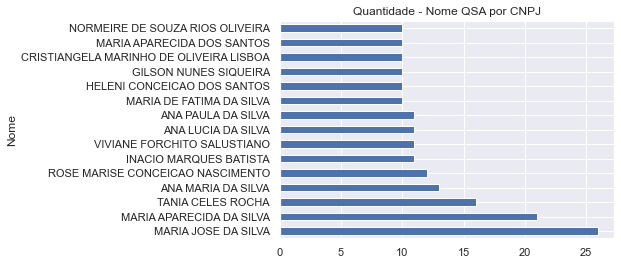

In [43]:
#EDA - Quantidade de Nomes por CNPJ - Alguns possíveis homônimos
df_qsa.groupby('nome').count().sort_values('cnpj8', 
                                           ascending=False).head(15)['cnpj8'].plot(kind='barh', 
                                                                                   ylabel='Quantidade', xlabel='Nome',
                                                                                  title = 'Quantidade - Nome QSA por CNPJ');

In [44]:
#Cálculo de quantidade de empresas por sócio (na base df_cnpj)
df_qsa = df_qsa.assign(qtde_emp_socio=df_qsa.groupby('nome')['cnpj8'].transform('count')).sort_values('qtde_emp_socio', 
                                                                                                      ascending=False)
df_qsa

,cnpj8,qual,nome,qtde_emp_socio
24175,01970215,16-Presidente,MARIA JOSE DA SILVA,26
40509,03225918,16-Presidente,MARIA JOSE DA SILVA,26
64992,08195529,16-Presidente,MARIA JOSE DA SILVA,26
64213,08032033,16-Presidente,MARIA JOSE DA SILVA,26
46448,03980488,16-Presidente,MARIA JOSE DA SILVA,26
...,...,...,...,...
43666,03546885,16-Presidente,CELIA REGINA MEZZENGA BIANCONI,1
43665,03545833,22-Sócio,CATHARINA FERNANDA BRUGNARA CERETTA,1
43664,03545833,49-Sócio-Administrador,JANE DAS CHAGAS LEBRE,1
43663,03545734,16-Presidente,APARECIDA AUGUSTINHO DA SILVA FERREIRA,1


In [45]:
# Criação de diferentes métricas de quantidades para agregar informações sobre os sócios
df_qsa_qtdes = df_qsa.groupby('cnpj8')['qtde_emp_socio'].agg(
    ['max','sum', 'count']).rename(columns={'max':'max_qtde_emp_socios', 
                                   'sum':'qtde_total_emp_socios',
                                           'count':'qtde_socios_na_emp'})

In [46]:
# Junção ao Dataframe principal - df_cnpj
df_cnpj = df_cnpj.merge(df_qsa_qtdes, how='left', left_on='cnpj8', right_on=df_qsa_qtdes.index, validate='1:1')

In [47]:
# Criação de métrica para quantidade de empresas distintas dos sócios na base
df_cnpj['qtde_empresas_distintas_socios'] = df_cnpj['qtde_total_emp_socios'] - df_cnpj['qtde_socios_na_emp'] + 1
df_cnpj

,cnpj,abertura,atividades_secundarias,tipo,qsa,situacao,porte,capital_social,cnae_cd,cnae_desc,cnae_class,cnpj8,max_qtde_emp_socios,qtde_total_emp_socios,qtde_socios_na_emp,qtde_empresas_distintas_socios
0,00.000.000/0001-91,01/08/1966,[{'text': 'Outras atividades de serviços finan...,MATRIZ,"[{'qual': '10-Diretor', 'nome': 'MARCIO HAMILT...",ATIVA,DEMAIS,90000000000.00,64.22-1-00,"Bancos múltiplos, com carteira comercial",ser_financeiros,00000000,1.00,59.00,59.00,1.00
1,00.000.049/0001-44,15/06/1994,"[{'code': '00.00-0-00', 'text': 'Não informada'}]",MATRIZ,"[{'qual': '16-Presidente', 'nome': 'FERNANDA G...",ATIVA,DEMAIS,0.00,94.99-5-00,Atividades associativas não especificadas ante...,ser_outros,00000049,1.00,1.00,1.00,1.00
2,00.000.304/0001-59,15/08/1994,"[{'code': '00.00-0-00', 'text': 'Não informada'}]",MATRIZ,"[{'qual': '16-Presidente', 'nome': 'JULIANA FA...",ATIVA,DEMAIS,0.00,94.99-5-00,Atividades associativas não especificadas ante...,ser_outros,00000304,2.00,2.00,1.00,2.00
3,00.005.306/0001-30,07/01/1983,[{'text': 'Atividades de organizações associat...,MATRIZ,"[{'qual': '16-Presidente', 'nome': 'MARIA SOCO...",ATIVA,DEMAIS,0.00,94.30-8-00,Atividades de associações de defesa de direito...,ser_outros,00005306,1.00,1.00,1.00,1.00
4,00.006.775/0001-74,19/08/1982,"[{'code': '00.00-0-00', 'text': 'Não informada'}]",MATRIZ,"[{'qual': '16-Presidente', 'nome': 'PAULO CEZA...",ATIVA,DEMAIS,0.00,85.13-9-00,Ensino fundamental,ser_educacao,00006775,1.00,2.00,2.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115702,98.418.304/0001-78,08/02/1972,[{'text': 'Atividades de organizações associat...,MATRIZ,"[{'qual': '16-Presidente', 'nome': 'DIOGO RICA...",ATIVA,DEMAIS,0.00,94.30-8-00,Atividades de associações de defesa de direito...,ser_outros,98418304,1.00,1.00,1.00,1.00
115703,98.591.910/0001-90,02/12/1966,[{'text': 'Atividades de atendimento em pronto...,MATRIZ,"[{'qual': '16-Presidente', 'nome': 'LUCIANO DE...",ATIVA,DEMAIS,0.00,86.10-1-01,"Atividades de atendimento hospitalar, exceto p...",ser_saude_sociais,98591910,1.00,1.00,1.00,1.00
115704,98.595.861/0001-64,16/03/1971,[{'text': 'Atividades de organizações associat...,MATRIZ,"[{'qual': '16-Presidente', 'nome': 'ADRIANA LU...",ATIVA,DEMAIS,0.00,94.30-8-00,Atividades de associações de defesa de direito...,ser_outros,98595861,1.00,1.00,1.00,1.00
115705,98.675.598/0001-13,17/09/1973,[{'text': 'Atividades de organizações associat...,MATRIZ,"[{'qual': '16-Presidente', 'nome': 'INES MORO'}]",ATIVA,DEMAIS,0.00,94.30-8-00,Atividades de associações de defesa de direito...,ser_outros,98675598,1.00,1.00,1.00,1.00


In [48]:
# Criação de métricas referentes ao(s) CNAE(s) secundário(s)
df_cnae_sec

,cnpj8,cnae_sec_cd,cnae_sec_desc
0,00000000,64.99-9-99,Outras atividades de serviços financeiros não ...
1,00000049,00.00-0-00,Não informada
2,00000304,00.00-0-00,Não informada
3,00005306,94.93-6-00,Atividades de organizações associativas ligada...
4,00005306,94.99-5-00,Atividades associativas não especificadas ante...
...,...,...,...
184245,98595861,94.93-6-00,Atividades de organizações associativas ligada...
184246,98595861,94.99-5-00,Atividades associativas não especificadas ante...
184247,98675598,94.93-6-00,Atividades de organizações associativas ligada...
184248,98675598,94.99-5-00,Atividades associativas não especificadas ante...


In [49]:
#Classifica CNAEs Secundários
df_cnae_sec = classifica_cnae(df_cnae_sec, 'cnae_sec_cd')

In [50]:
#Criação de métricas de quantidade de códigos CNAE secundário diferentes e CNAE classicados por atividade (Divisão)
df_cnae_sec_qtdes = df_cnae_sec.groupby('cnpj8')['cnae_sec_cd', 
                    'cnae_class'].nunique().rename(columns={'cnae_sec_cd':'qtde_cnaes_sec', 'cnae_class':'qtde_categ_cnaes_sec'})

C:\Users\vinic\AppData\Local\Temp/ipykernel_8916/3666639049.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_cnae_sec_qtdes = df_cnae_sec.groupby('cnpj8')['cnae_sec_cd',


In [51]:
#Junção dos dataframes para incorporar as métricas de CNAE secundário
df_cnpj = df_cnpj.merge(df_cnae_sec_qtdes, how='left', left_on='cnpj8', right_on=df_cnae_sec_qtdes.index, validate='1:1')

In [52]:
#Calcula tempo de abertura da empresa
df_cnpj['tempo_abertura'] = (pd.to_datetime('now') - pd.to_datetime(df_cnpj['abertura'])).dt.days.astype('Int64')
df_cnpj.head()

,cnpj,abertura,atividades_secundarias,tipo,qsa,situacao,porte,capital_social,cnae_cd,cnae_desc,cnae_class,cnpj8,max_qtde_emp_socios,qtde_total_emp_socios,qtde_socios_na_emp,qtde_empresas_distintas_socios,qtde_cnaes_sec,qtde_categ_cnaes_sec,tempo_abertura
0,00.000.000/0001-91,01/08/1966,[{'text': 'Outras atividades de serviços finan...,MATRIZ,"[{'qual': '10-Diretor', 'nome': 'MARCIO HAMILT...",ATIVA,DEMAIS,90000000000.00,64.22-1-00,"Bancos múltiplos, com carteira comercial",ser_financeiros,00000000,1.00,59.00,59.00,1.00,1,1,20460
1,00.000.049/0001-44,15/06/1994,"[{'code': '00.00-0-00', 'text': 'Não informada'}]",MATRIZ,"[{'qual': '16-Presidente', 'nome': 'FERNANDA G...",ATIVA,DEMAIS,0.00,94.99-5-00,Atividades associativas não especificadas ante...,ser_outros,00000049,1.00,1.00,1.00,1.00,1,1,10075
2,00.000.304/0001-59,15/08/1994,"[{'code': '00.00-0-00', 'text': 'Não informada'}]",MATRIZ,"[{'qual': '16-Presidente', 'nome': 'JULIANA FA...",ATIVA,DEMAIS,0.00,94.99-5-00,Atividades associativas não especificadas ante...,ser_outros,00000304,2.00,2.00,1.00,2.00,1,1,10014
3,00.005.306/0001-30,07/01/1983,[{'text': 'Atividades de organizações associat...,MATRIZ,"[{'qual': '16-Presidente', 'nome': 'MARIA SOCO...",ATIVA,DEMAIS,0.00,94.30-8-00,Atividades de associações de defesa de direito...,ser_outros,00005306,1.00,1.00,1.00,1.00,7,2,14077
4,00.006.775/0001-74,19/08/1982,"[{'code': '00.00-0-00', 'text': 'Não informada'}]",MATRIZ,"[{'qual': '16-Presidente', 'nome': 'PAULO CEZA...",ATIVA,DEMAIS,0.00,85.13-9-00,Ensino fundamental,ser_educacao,00006775,1.00,2.00,2.00,1.00,1,1,14393


In [53]:
#Remoção das colunas já trabalhadas e/ou desnecessárias
df_cnpj = df_cnpj[['cnpj8', 'cnpj', 'abertura', 'tempo_abertura','situacao', 'porte', 
                   'capital_social', 'cnae_cd', 'cnae_desc', 'cnae_class', 
                   'max_qtde_emp_socios','qtde_total_emp_socios','qtde_socios_na_emp',
                  'qtde_empresas_distintas_socios','qtde_cnaes_sec','qtde_categ_cnaes_sec']]
df_cnpj.head()

,cnpj8,cnpj,abertura,tempo_abertura,situacao,porte,capital_social,cnae_cd,cnae_desc,cnae_class,max_qtde_emp_socios,qtde_total_emp_socios,qtde_socios_na_emp,qtde_empresas_distintas_socios,qtde_cnaes_sec,qtde_categ_cnaes_sec
0,00000000,00.000.000/0001-91,01/08/1966,20460,ATIVA,DEMAIS,90000000000.00,64.22-1-00,"Bancos múltiplos, com carteira comercial",ser_financeiros,1.00,59.00,59.00,1.00,1,1
1,00000049,00.000.049/0001-44,15/06/1994,10075,ATIVA,DEMAIS,0.00,94.99-5-00,Atividades associativas não especificadas ante...,ser_outros,1.00,1.00,1.00,1.00,1,1
2,00000304,00.000.304/0001-59,15/08/1994,10014,ATIVA,DEMAIS,0.00,94.99-5-00,Atividades associativas não especificadas ante...,ser_outros,2.00,2.00,1.00,2.00,1,1
3,00005306,00.005.306/0001-30,07/01/1983,14077,ATIVA,DEMAIS,0.00,94.30-8-00,Atividades de associações de defesa de direito...,ser_outros,1.00,1.00,1.00,1.00,7,2
4,00006775,00.006.775/0001-74,19/08/1982,14393,ATIVA,DEMAIS,0.00,85.13-9-00,Ensino fundamental,ser_educacao,1.00,2.00,2.00,1.00,1,1


## Junção das bases df_cnpj e df_portal para criação da base que será alimentada ao modelo

In [54]:
df_final = df_portal.merge(df_cnpj, how='left', left_on='cnpj8', right_on='cnpj8', validate='m:1')
df_final = df_final[['ano', 'cnpj8', 'cnpj', 'abertura', 'tempo_abertura', 'situacao', 'porte', 'capital_social',
                    'tp_favorecido', 'cnae_cd', 'cnae_desc', 'cnae_class', 'nm_funcao', 'qt_nm_orgao', 'qt_nm_subfuncao',
                    'qt_nm_programa', 'qt_nm_acao', 'qt_nm_modalid_aplic_despesa', 'qt_nm_elemento_despesa', 'qt_filiais',
                    'max_qtde_emp_socios', 'qtde_total_emp_socios', 'qtde_socios_na_emp', 'qtde_empresas_distintas_socios',
                    'qtde_cnaes_sec', 'qtde_categ_cnaes_sec', 'vl_transferido']]
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320520 entries, 0 to 320519
Data columns (total 27 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   ano                             320520 non-null  category
 1   cnpj8                           320520 non-null  object  
 2   cnpj                            320520 non-null  object  
 3   abertura                        320520 non-null  object  
 4   tempo_abertura                  320520 non-null  Int64   
 5   situacao                        320520 non-null  object  
 6   porte                           320520 non-null  object  
 7   capital_social                  320520 non-null  float64 
 8   tp_favorecido                   320520 non-null  category
 9   cnae_cd                         320520 non-null  object  
 10  cnae_desc                       320520 non-null  object  
 11  cnae_class                      320520 non-null  object  
 12  nm

In [55]:
# Tratando Missing Values
model_df = df_final.copy()
model_df[['max_qtde_emp_socios', 'qtde_total_emp_socios', 
          'qtde_socios_na_emp','qtde_empresas_distintas_socios']] = model_df[['max_qtde_emp_socios', 
                                                                              'qtde_total_emp_socios', 'qtde_socios_na_emp',
                                                                              'qtde_empresas_distintas_socios']].fillna(0)
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320520 entries, 0 to 320519
Data columns (total 27 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   ano                             320520 non-null  category
 1   cnpj8                           320520 non-null  object  
 2   cnpj                            320520 non-null  object  
 3   abertura                        320520 non-null  object  
 4   tempo_abertura                  320520 non-null  Int64   
 5   situacao                        320520 non-null  object  
 6   porte                           320520 non-null  object  
 7   capital_social                  320520 non-null  float64 
 8   tp_favorecido                   320520 non-null  category
 9   cnae_cd                         320520 non-null  object  
 10  cnae_desc                       320520 non-null  object  
 11  cnae_class                      320520 non-null  object  
 12  nm

## Análise e Exploração de Dados

In [56]:
model_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tempo_abertura,320520.00,8006.90,3843.24,407.00,4724.00,8264.00,9251.00,39949.00
capital_social,320520.00,12762737.29,1057837854.95,0.00,0.00,0.00,0.00,90000000000.00
qt_nm_orgao,320520.00,1.02,1.28,0.00,1.00,1.00,1.00,99.00
qt_nm_subfuncao,320520.00,1.01,0.39,1.00,1.00,1.00,1.00,32.00
qt_nm_programa,320520.00,1.96,0.52,1.00,2.00,2.00,2.00,40.00
qt_nm_acao,320520.00,1.02,0.65,1.00,1.00,1.00,1.00,52.00
qt_nm_modalid_aplic_despesa,320520.00,1.01,0.11,1.00,1.00,1.00,1.00,7.00
qt_nm_elemento_despesa,320520.00,1.49,0.54,1.00,1.00,1.00,2.00,11.00
qt_filiais,320520.00,1.00,0.08,1.00,1.00,1.00,1.00,9.00
max_qtde_emp_socios,320520.00,1.11,0.76,0.00,1.00,1.00,1.00,26.00


In [57]:
model_df.describe(exclude='number').transpose()

,count,unique,top,freq
ano,320520,3,2018,108528
cnpj8,320520,115707,00000000,44
cnpj,320520,115707,00.000.000/0001-91,44
abertura,320520,12174,26/06/1997,1514
situacao,320520,5,ATIVA,318639
porte,320520,3,DEMAIS,320046
tp_favorecido,320520,2,Entidades Sem Fins Lucrativos,319410
cnae_cd,320520,208,94.30-8-00,173485
cnae_desc,320520,229,Atividades de associações de defesa de direito...,173305
cnae_class,320520,21,ser_outros,213246


In [58]:
model_df.query('abertura == "26/06/1997"').describe(exclude='number')

,ano,cnpj8,cnpj,abertura,situacao,porte,tp_favorecido,cnae_cd,cnae_desc,cnae_class,nm_funcao
count,1514,1514,1514,1514,1514,1514,1514,1514,1514,1514,1514
unique,3,537,537,1,3,1,1,12,12,5,1
top,2018,01925357,01.925.357/0001-43,26/06/1997,ATIVA,DEMAIS,Entidades Sem Fins Lucrativos,94.30-8-00,Atividades de associações de defesa de direito...,ser_outros,Educação
freq,514,3,3,1514,1507,1514,1514,1132,1132,1172,1514


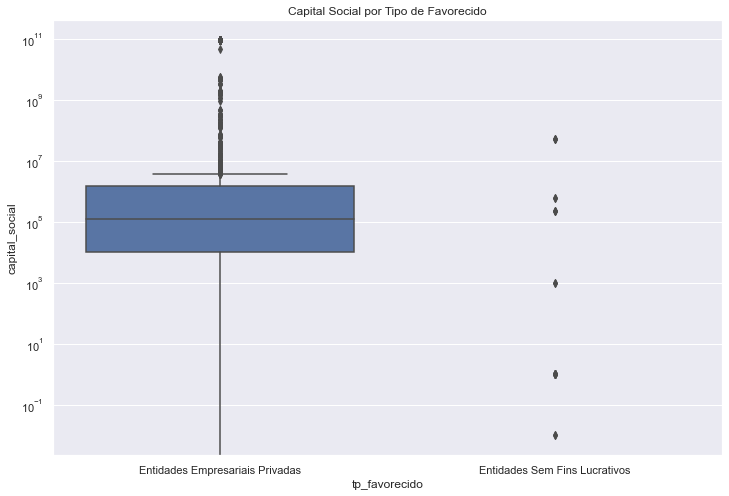

In [59]:
box_favorecido = sns.boxplot(data=model_df, x='tp_favorecido', y='capital_social')
box_favorecido.set(yscale='log')
plt.title('Capital Social por Tipo de Favorecido')
box_favorecido.figure.set_figheight(8)
box_favorecido.figure.set_figwidth(12)

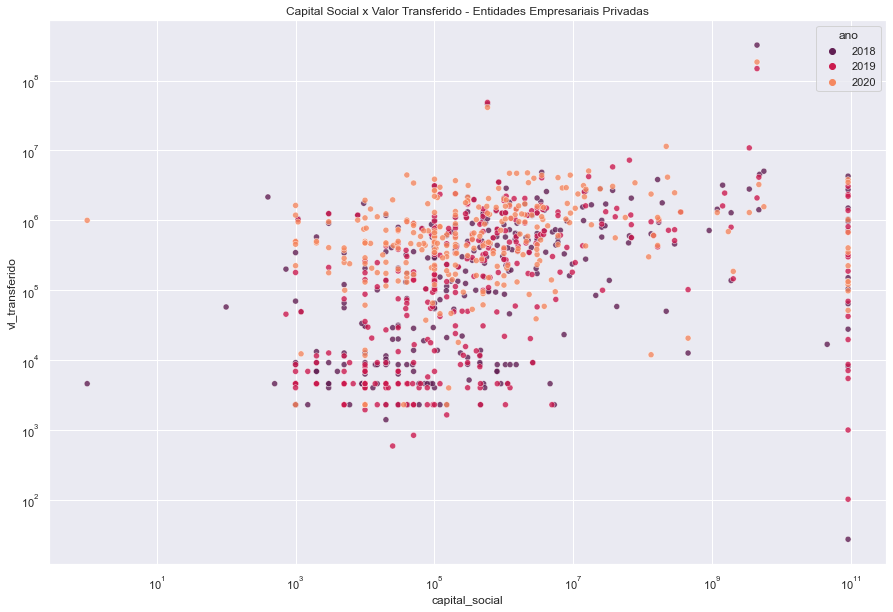

In [60]:
cap_social = sns.scatterplot(data=model_df.query('tp_favorecido == "Entidades Empresariais Privadas"'), 
                              x='capital_social', y='vl_transferido', alpha=0.8,
                             hue = 'ano', palette='rocket')
cap_social.set(yscale='log')
cap_social.set(xscale='log')
plt.title('Capital Social x Valor Transferido - Entidades Empresariais Privadas')
cap_social.figure.set_figheight(10)
cap_social.figure.set_figwidth(15)

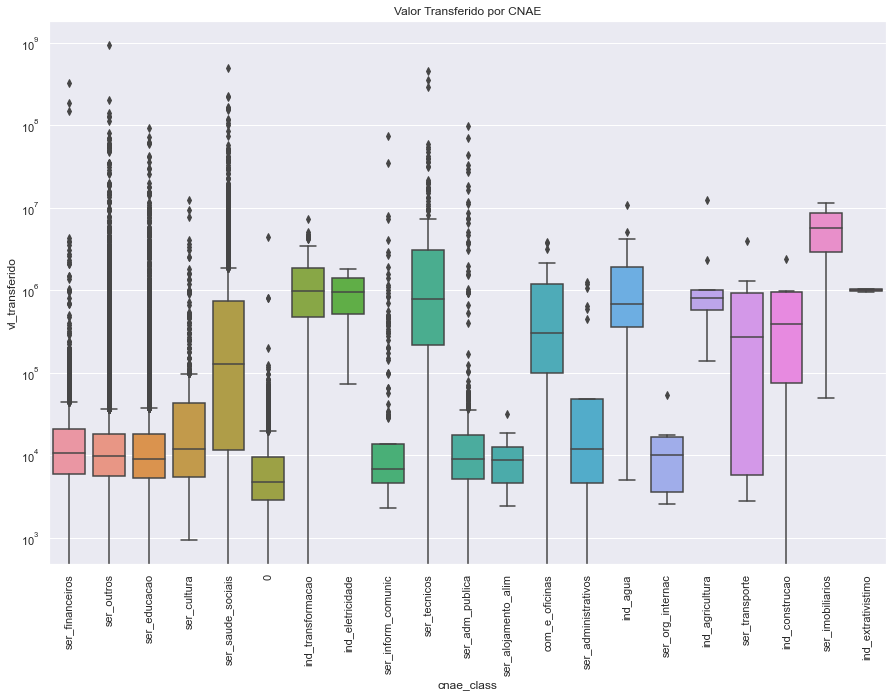

In [61]:
g = sns.boxplot(data=model_df, x='cnae_class', y='vl_transferido');
g.set(yscale='log')
#g.set_xticklabels(rotation=30)
plt.xticks(rotation=90)
plt.title('Valor Transferido por CNAE')
g.figure.set_figheight(10)
g.figure.set_figwidth(15)

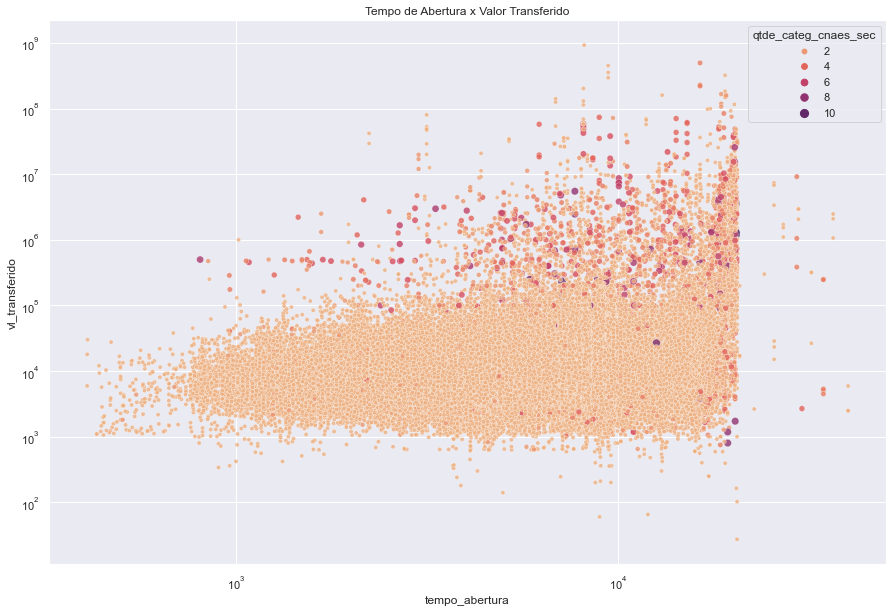

In [62]:
tempo_abert = sns.scatterplot(data=model_df, x='tempo_abertura', y='vl_transferido', 
                size='qtde_categ_cnaes_sec', hue='qtde_categ_cnaes_sec', alpha=0.8,
               palette='flare')
tempo_abert.set(yscale='log')
tempo_abert.set(xscale='log')
plt.title('Tempo de Abertura x Valor Transferido')
tempo_abert.figure.set_figheight(10)
tempo_abert.figure.set_figwidth(15)

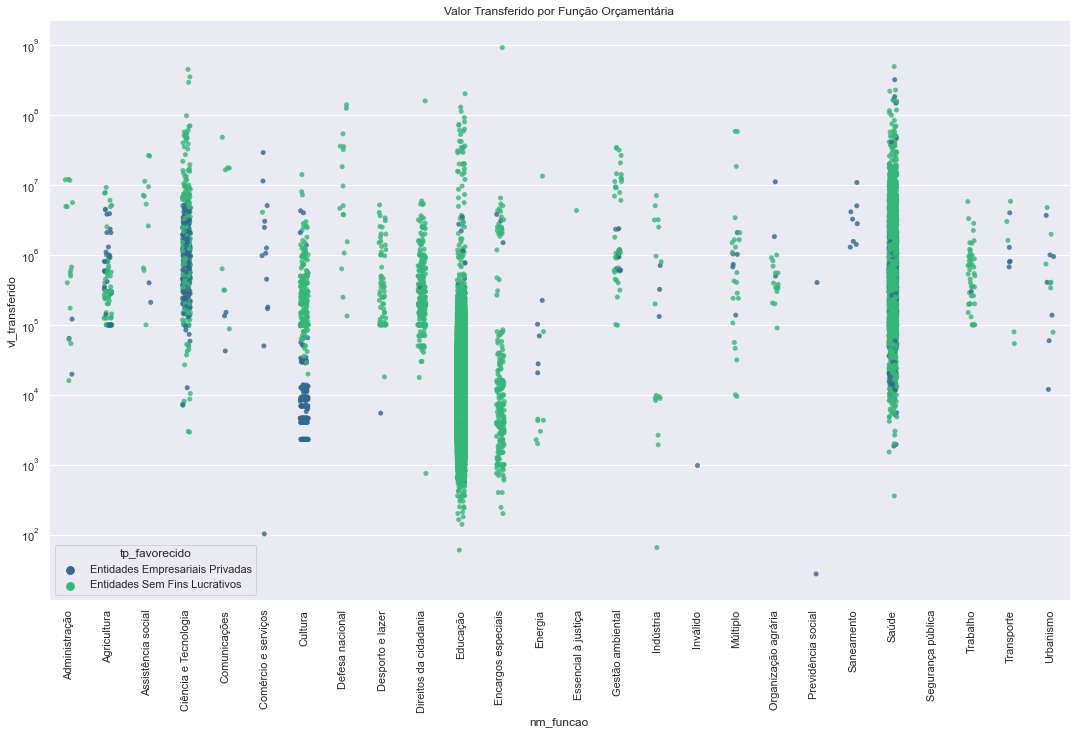

In [63]:
cat = sns.catplot(data=model_df, x='nm_funcao', y='vl_transferido', palette='viridis', kind='strip', 
                  hue='tp_favorecido', legend_out=False, alpha=0.8)
cat.set(yscale='log')
plt.xticks(rotation=90)
plt.title('Valor Transferido por Função Orçamentária')
cat.figure.set_figheight(10)
cat.figure.set_figwidth(18)

In [64]:
# One Hot Encoding variáveis categóricas usando Pandas (get_dummies)
categorias = ['situacao','porte','tp_favorecido','cnae_class','nm_funcao']
onehot = pd.get_dummies(model_df[categorias])
model_df = model_df.join(onehot)
model_df = model_df.drop(categorias, axis=1)
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320520 entries, 0 to 320519
Data columns (total 79 columns):
 #   Column                                         Non-Null Count   Dtype   
---  ------                                         --------------   -----   
 0   ano                                            320520 non-null  category
 1   cnpj8                                          320520 non-null  object  
 2   cnpj                                           320520 non-null  object  
 3   abertura                                       320520 non-null  object  
 4   tempo_abertura                                 320520 non-null  Int64   
 5   capital_social                                 320520 non-null  float64 
 6   cnae_cd                                        320520 non-null  object  
 7   cnae_desc                                      320520 non-null  object  
 8   qt_nm_orgao                                    320520 non-null  int64   
 9   qt_nm_subfuncao           

In [65]:
#Normalizando os valores usando Pandas (MinMax)
cols_norm = model_df.select_dtypes('number').columns
model_df_norm = model_df.copy()
model_df_norm[cols_norm] = (model_df_norm[cols_norm] - model_df_norm[cols_norm].min())/(model_df_norm[cols_norm].max() - model_df_norm[cols_norm].min())
model_df_norm

,ano,cnpj8,cnpj,abertura,tempo_abertura,capital_social,cnae_cd,cnae_desc,qt_nm_orgao,qt_nm_subfuncao,qt_nm_programa,qt_nm_acao,qt_nm_modalid_aplic_despesa,qt_nm_elemento_despesa,qt_filiais,max_qtde_emp_socios,qtde_total_emp_socios,qtde_socios_na_emp,qtde_empresas_distintas_socios,qtde_cnaes_sec,qtde_categ_cnaes_sec,vl_transferido,situacao_ATIVA,situacao_BAIXADA,situacao_INAPTA,situacao_NULA,situacao_SUSPENSA,porte_DEMAIS,porte_EMPRESA DE PEQUENO PORTE,porte_MICRO EMPRESA,tp_favorecido_Entidades Empresariais Privadas,tp_favorecido_Entidades Sem Fins Lucrativos,cnae_class_0,cnae_class_com_e_oficinas,cnae_class_ind_agricultura,cnae_class_ind_agua,cnae_class_ind_construcao,cnae_class_ind_eletricidade,cnae_class_ind_extrativistimo,cnae_class_ind_transformacao,cnae_class_ser_adm_publica,cnae_class_ser_administrativos,cnae_class_ser_alojamento_alim,cnae_class_ser_cultura,cnae_class_ser_educacao,cnae_class_ser_financeiros,cnae_class_ser_imobiliarios,cnae_class_ser_inform_comunic,cnae_class_ser_org_internac,cnae_class_ser_outros,cnae_class_ser_saude_sociais,cnae_class_ser_tecnicos,cnae_class_ser_transporte,nm_funcao_Administração,nm_funcao_Agricultura,nm_funcao_Assistência social,nm_funcao_Ciência e Tecnologia,nm_funcao_Comunicações,nm_funcao_Comércio e serviços,nm_funcao_Cultura,nm_funcao_Defesa nacional,nm_funcao_Desporto e lazer,nm_funcao_Direitos da cidadania,nm_funcao_Educação,nm_funcao_Encargos especiais,nm_funcao_Energia,nm_funcao_Essencial à justiça,nm_funcao_Gestão ambiental,nm_funcao_Indústria,nm_funcao_Inválido,nm_funcao_Múltiplo,nm_funcao_Organização agrária,nm_funcao_Previdência social,nm_funcao_Saneamento,nm_funcao_Saúde,nm_funcao_Segurança pública,nm_funcao_Trabalho,nm_funcao_Transporte,nm_funcao_Urbanismo
0,2018,00000000,00.000.000/0001-91,01/08/1966,0.51,1.00,64.22-1-00,"Bancos múltiplos, com carteira comercial",1.00,1.00,1.00,1.00,1.00,0.50,0.62,0.04,1.00,1.00,0.04,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
1,2018,00000000,00.000.000/0001-91,01/08/1966,0.51,1.00,64.22-1-00,"Bancos múltiplos, com carteira comercial",1.00,1.00,1.00,1.00,1.00,0.50,0.62,0.04,1.00,1.00,0.04,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2018,00000000,00.000.000/0001-91,01/08/1966,0.51,1.00,64.22-1-00,"Bancos múltiplos, com carteira comercial",1.00,1.00,1.00,1.00,1.00,0.50,0.62,0.04,1.00,1.00,0.04,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,2018,00000000,00.000.000/0001-91,01/08/1966,0.51,1.00,64.22-1-00,"Bancos múltiplos, com carteira comercial",1.00,1.00,1.00,1.00,1.00,0.50,0.62,0.04,1.00,1.00,0.04,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,2018,00000000,00.000.000/0001-91,01/08/1966,0.51,1.00,64.22-1-00,"Bancos múltiplos, com carteira comercial",1.00,1.00,1.00,1.00,1.00,0.50,0.62,0.04,1.00,1.00,0.04,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0

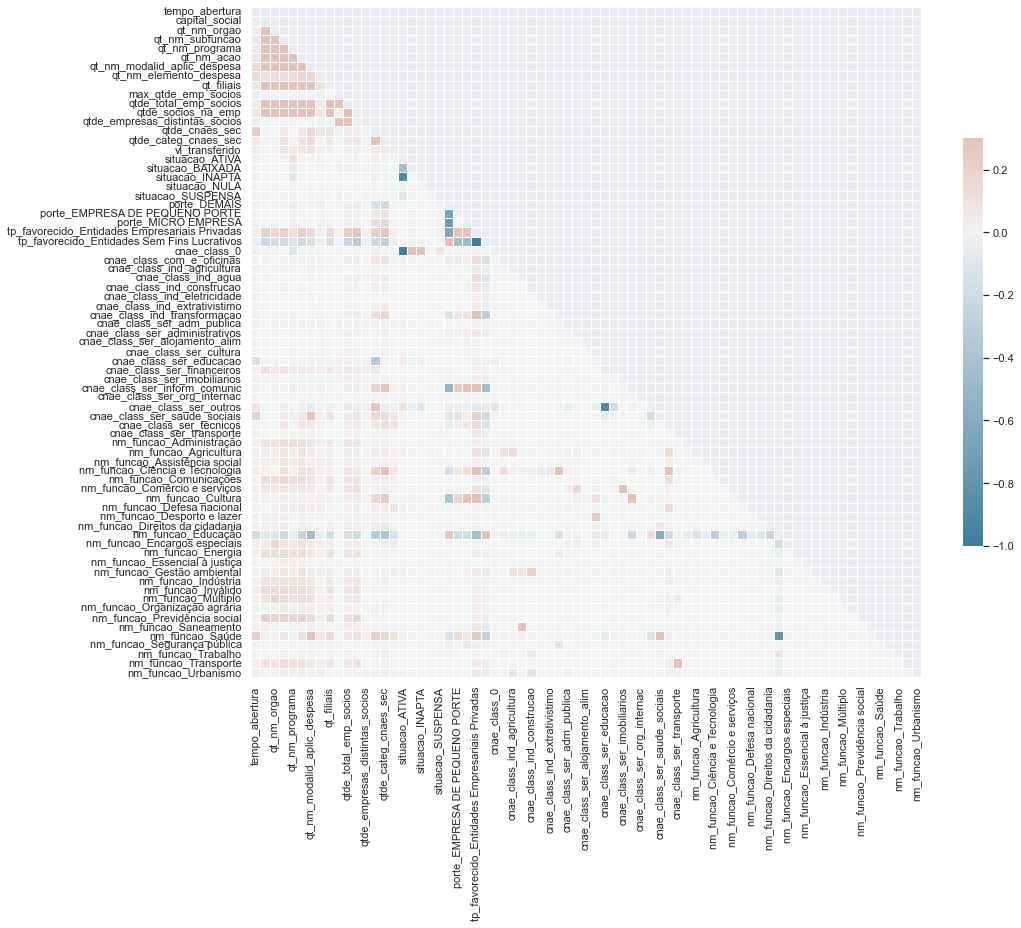

In [66]:
# Matriz de correlação das variáveis

corr = model_df_norm.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

## Modelos

### Autoencoder

In [88]:
from pyod.models.auto_encoder import AutoEncoder
clf_ae = AutoEncoder(batch_size=512, epochs=30, contamination=0.01, hidden_neurons=[64,32,16,32,64], 
                  l2_regularizer=0.05, dropout_rate=0.1, random_state=123)
clf_ae.fit(model_df_norm.select_dtypes('number'))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 73)                5402      
                                                                 
 dropout_7 (Dropout)         (None, 73)                0         
                                                                 
 dense_9 (Dense)             (None, 73)                5402      
                                                                 
 dropout_8 (Dropout)         (None, 73)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                4736      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 32)               

AutoEncoder(batch_size=512, contamination=0.01, dropout_rate=0.1, epochs=30,
      hidden_activation='relu', hidden_neurons=[64, 32, 16, 32, 64],
      l2_regularizer=0.05,
      loss=<function mean_squared_error at 0x0000020E83A2E280>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=123, validation_size=0.1, verbose=1)

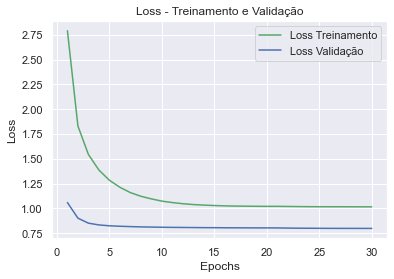

In [89]:
ae_loss_train = clf_ae.history_['loss']
ae_loss_val = clf_ae.history_['val_loss']
epochs = range(1,31)
plt.plot(epochs, ae_loss_train, 'g', label='Loss Treinamento')
plt.plot(epochs, ae_loss_val, 'b', label='Loss Validação')
plt.title('Loss - Treinamento e Validação')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [90]:
clf_ae.labels_

array([1, 1, 1, ..., 0, 0, 0])

In [91]:
clf_ae.threshold_

27.959442101553584

In [92]:
#Retornando as informações para o DataFrame original
result_df = df_final.copy()
result_df['anomalia_ae'] = clf_ae.labels_
result_df['scores_ae'] = clf_ae.decision_scores_
result_df['anomalia_ae'].value_counts()

0    317314
1      3206
Name: anomalia_ae, dtype: int64

In [93]:
result_df[result_df['anomalia_ae'] == 1].head(50)

,ano,cnpj8,cnpj,abertura,tempo_abertura,situacao,porte,capital_social,tp_favorecido,cnae_cd,cnae_desc,cnae_class,nm_funcao,qt_nm_orgao,qt_nm_subfuncao,qt_nm_programa,qt_nm_acao,qt_nm_modalid_aplic_despesa,qt_nm_elemento_despesa,qt_filiais,max_qtde_emp_socios,qtde_total_emp_socios,qtde_socios_na_emp,qtde_empresas_distintas_socios,qtde_cnaes_sec,qtde_categ_cnaes_sec,vl_transferido,anomalia_ae,scores_ae
0,2018,00000000,00.000.000/0001-91,01/08/1966,20460,ATIVA,DEMAIS,90000000000.00,Entidades Empresariais Privadas,64.22-1-00,"Bancos múltiplos, com carteira comercial",ser_financeiros,Saúde,99,32,40,52,7,6,6,1.00,59.00,59.00,1.00,1,1,8138.56,1,210.23
1,2018,00000000,00.000.000/0001-91,01/08/1966,20460,ATIVA,DEMAIS,90000000000.00,Entidades Empresariais Privadas,64.22-1-00,"Bancos múltiplos, com carteira comercial",ser_financeiros,Ciência e Tecnologia,99,32,40,52,7,6,6,1.00,59.00,59.00,1.00,1,1,104001.65,1,211.45
2,2018,00000000,00.000.000/0001-91,01/08/1966,20460,ATIVA,DEMAIS,90000000000.00,Entidades Empresariais Privadas,64.22-1-00,"Bancos múltiplos, com carteira comercial",ser_financeiros,Gestão ambiental,99,32,40,52,7,6,6,1.00,59.00,59.00,1.00,1,1,965874.87,1,224.74
3,2018,00000000,00.000.000/0001-91,01/08/1966,20460,ATIVA,DEMAIS,90000000000.00,Entidades Empresariais Privadas,64.22-1-00,"Bancos múltiplos, com carteira comercial",ser_financeiros,Encargos especiais,99,32,40,52,7,6,6,1.00,59.00,59.00,1.00,1,1,1499746.52,1,213.82
4,2018,00000000,00.000.000/0001-91,01/08/1966,20460,ATIVA,DEMAIS,90000000000.00,Entidades Empresariais Privadas,64.22-1-00,"Bancos múltiplos, com carteira comercial",ser_financeiros,Múltiplo,99,32,40,52,7,6,6,1.00,59.00,59.00,1.00,1,1,1032567.85,1,235.67
5,2018,00000000,00.000.000/0001-91,01/08/1966,20460,ATIVA,DEMAIS,90000000000.00,Entidades Empresariais Privadas,64.22-1-00,"Bancos múltiplos, com carteira comercial",ser_financeiros,Educação,99,32,40,52,7,6,6,1.00,59.00,59.00,1.00,1,1,2757631.83,1,209.87
6,2018,00000000,00.000.000/0001-91,01/08/1966,20460,ATIVA,DEMAIS,90000000000.00,Entidades Empresariais Privadas,64.22-1-00,"Bancos múltiplos, com carteira comercial",ser_financeiros,Cultura,99,32,40,52,7,6,6,1.00,59.00,59.00,1.00,1,1,4288361.79,1,211.63
7,2018,00000000,00.000.000/0001-91,01/08/1966,20460,ATIVA,DEMAIS,90000000000.00,Entidades Empresariais Privadas,64.22-1-00,"Bancos múltiplos, com carteira comercial",ser_financeiros,Previdência social,99,32,40,52,7,6,6,1.00,59.00,59.00,1.00,1,1,27.33,1,452.05
8,2018,00000000,00.000.000/0001-91,01/08/1966,20460,ATIVA,DEMAIS,90000000000.00,Entidades Empresariais Privadas,64.22-1-00,"Bancos múltiplos, com carteira comercial",ser_financeiros,Administração,99,32,40,52,7,6,6,1.00,59.00,59.00,1.00,1,1,64216.00,1,248.79
9,2018,00000000,00.000.000/0001-91,01/08/1966,20460,ATIVA,DEMAIS,90000000000.00,Entidades Empresariais Privadas,64.22-1-00,"Bancos múltiplos, com carteira comercial",ser_financeiros,Comunicações,99,32,40,52,7,6,6,1.00,59.00,59.00,1.00,1,1,150824.00,1,270.61


### Isolation Forest

In [94]:
from pyod.models.iforest import IForest
clf_if = IForest(verbose=1, contamination=0.01, n_jobs=-1, random_state=123)
clf_if.fit(model_df_norm.select_dtypes('number'))

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    4.6s remaining:   42.2s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    5.3s finished


IForest(behaviour='old', bootstrap=False, contamination=0.01,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
    random_state=123, verbose=1)

In [95]:
clf_if.labels_

array([1, 1, 1, ..., 1, 0, 0])

In [96]:
clf_if.threshold_

-0.0

In [97]:
clf_if.decision_scores_

array([ 0.13011695,  0.11394816,  0.12075341, ...,  0.03025123,
       -0.29346504, -0.29754493])

In [98]:
# Retornando as informações para o DataFrame original
result_df['anomalia_if'] = clf_if.labels_
result_df['scores_if'] = clf_if.decision_scores_
result_df['anomalia_if'].value_counts()

0    317316
1      3204
Name: anomalia_if, dtype: int64

### KNN

In [99]:
from pyod.models.knn import KNN
clf_knn = KNN(n_neighbors=10, contamination=0.01, n_jobs=-1, metric='minkowski')
clf_knn.fit(model_df_norm.select_dtypes('number'))

KNN(algorithm='auto', contamination=0.01, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
  radius=1.0)

In [100]:
clf_knn.labels_

array([1, 1, 1, ..., 0, 0, 0])

In [101]:
clf_knn.threshold_

0.10006296739597859

In [102]:
clf_knn.decision_scores_

array([1.41421356e+00, 1.41421356e+00, 1.41421368e+00, ...,
       1.62535382e-02, 5.31115561e-04, 1.01219857e-04])

In [103]:
# Retornando as informações para o DataFrame original
result_df['anomalia_knn'] = clf_knn.labels_
result_df['scores_knn'] = clf_knn.decision_scores_
result_df['anomalia_knn'].value_counts()

0    317314
1      3206
Name: anomalia_knn, dtype: int64

## Resultados - Interpretação e Avaliação

In [104]:
result_df[['anomalia_ae', 'anomalia_if', 'anomalia_knn']].query('anomalia_ae != anomalia_if or anomalia_ae != anomalia_knn')

,anomalia_ae,anomalia_if,anomalia_knn
58,1,0,1
62,1,1,0
64,1,1,0
144,1,0,0
145,1,1,0
...,...,...,...
320444,0,1,0
320510,0,1,0
320511,0,1,0
320515,0,1,0


In [105]:
result_df[['anomalia_ae', 'anomalia_if', 'anomalia_knn']].query('anomalia_ae == anomalia_if and anomalia_if == anomalia_knn and anomalia_ae == 1')

,anomalia_ae,anomalia_if,anomalia_knn
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1
...,...,...,...
320342,1,1,1
320364,1,1,1
320365,1,1,1
320406,1,1,1


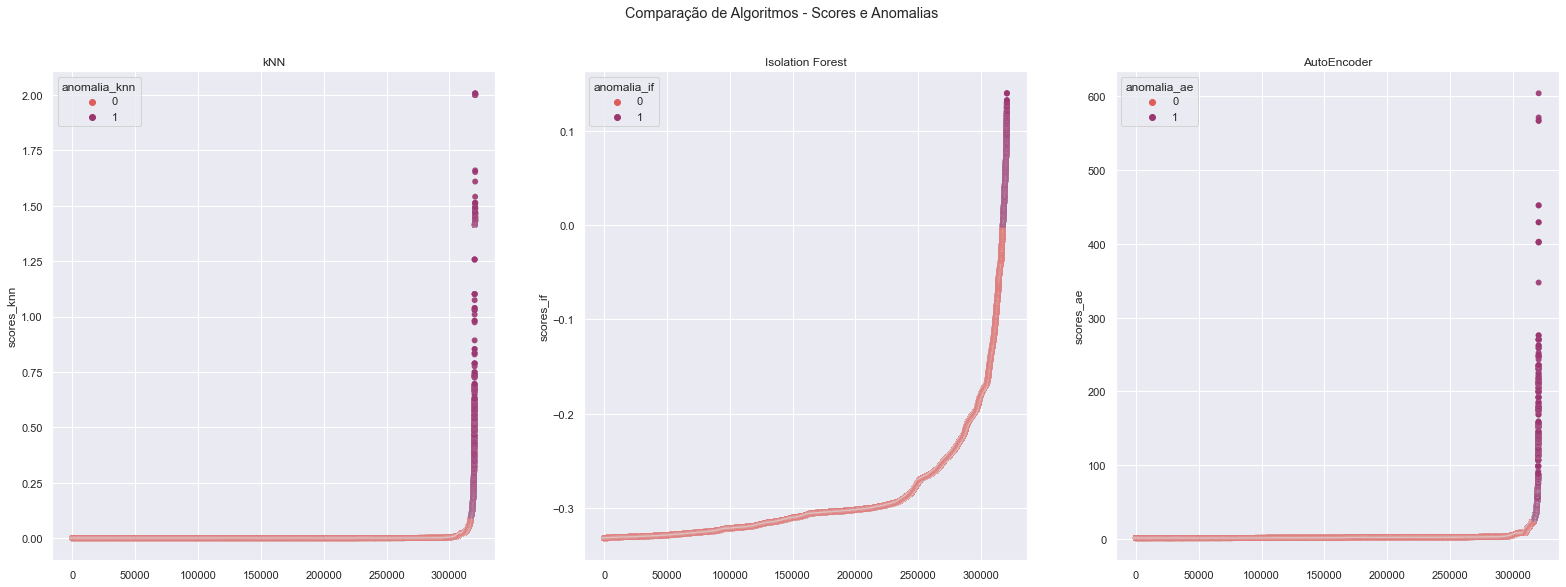

In [106]:
# Comparativo de Algoritmos - Scores e Anomalias
scores = ['scores_knn', 'scores_if', 'scores_ae']
anomalias = ['anomalia_knn', 'anomalia_if', 'anomalia_ae']
titulos = ['kNN', 'Isolation Forest', 'AutoEncoder']
fig, axes = plt.subplots(1, 3, figsize=(27,9),sharey=False)
fig.suptitle('Comparação de Algoritmos - Scores e Anomalias')
for i in range (0,3):
    df=result_df.sort_values(by=scores[i], ignore_index=True)
    sns.scatterplot(ax=axes[i], data=df, x=df.index, y=scores[i], hue=df[anomalias[i]],
                   alpha=0.9, palette='flare', linewidth=0.05)
    plt.subplots_adjust(wspace = 0.2)
    #axes[i].set(yscale='log')
    #axes[i].set(xscale='log')
    axes[i].set_title(titulos[i])

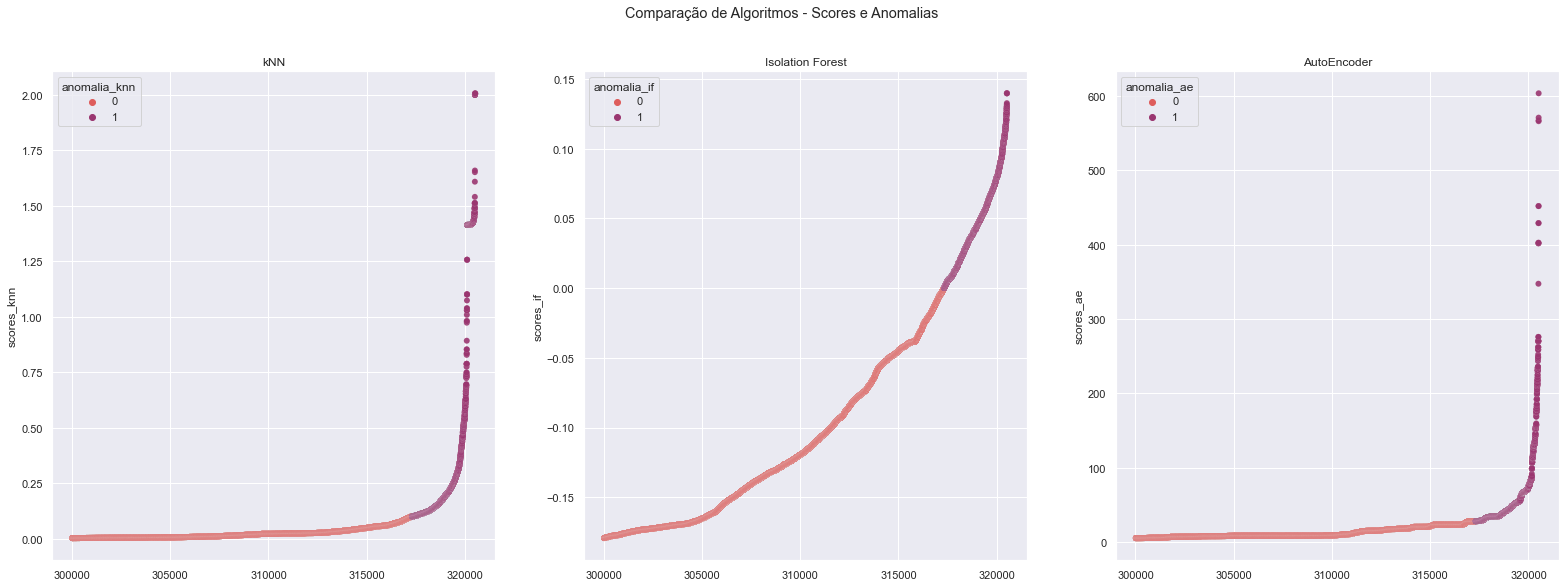

In [107]:
# Zoom nos últimos 20500 itens
scores = ['scores_knn', 'scores_if', 'scores_ae']
anomalias = ['anomalia_knn', 'anomalia_if', 'anomalia_ae']
titulos = ['kNN', 'Isolation Forest', 'AutoEncoder']
fig, axes = plt.subplots(1, 3, figsize=(27,9),sharey=False)
fig.suptitle('Comparação de Algoritmos - Scores e Anomalias')
for i in range (0,3):
    df=result_df.sort_values(by=scores[i], ignore_index=True).tail(20500)
    sns.scatterplot(ax=axes[i], data=df, x=df.index, y=scores[i], hue=df[anomalias[i]],
                   alpha=0.9, palette='flare', linewidth=0.05)
    plt.subplots_adjust(wspace = 0.2)
    #axes[i].set(yscale='log')
    #axes[i].set(xscale='log')
    axes[i].set_title(titulos[i])

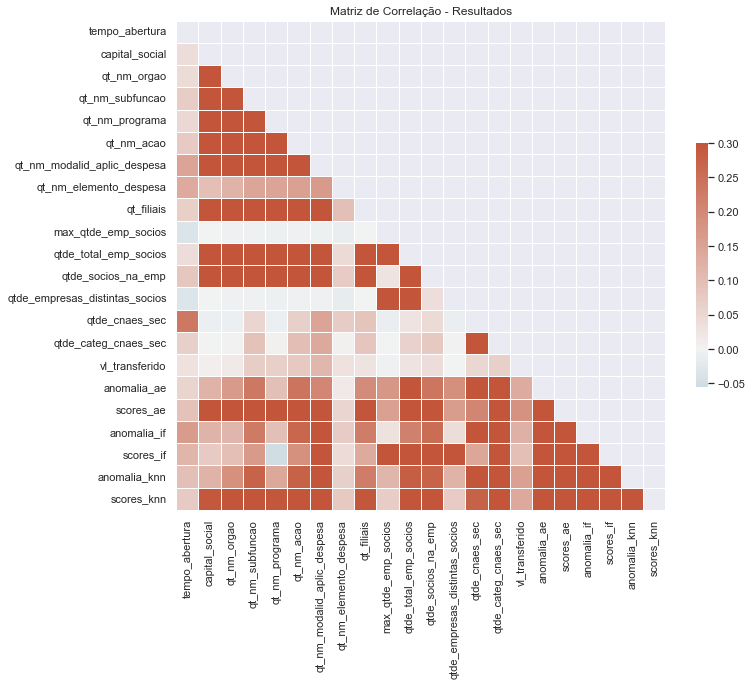

In [108]:
# Matriz de correlação das variáveis

corr = result_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Matriz de Correlação - Resultados');

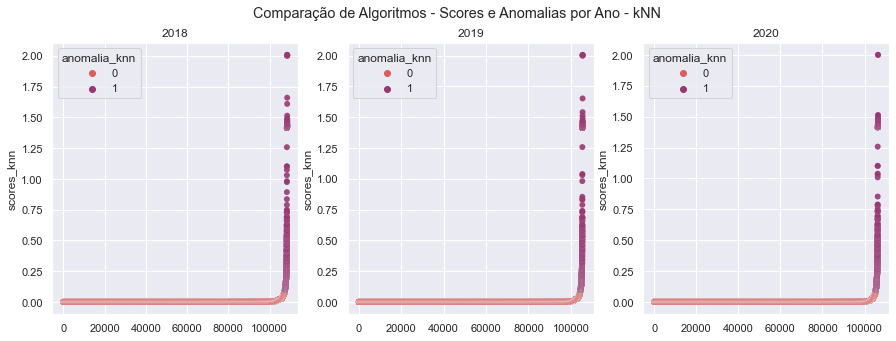

In [127]:
# Comparativo de Algoritmos - Scores e Anomalias por Ano - kNN
anos = ['2018', '2019', '2020']
fig, axes = plt.subplots(1, 3, figsize=(15,5),sharey=False)
fig.suptitle('Comparação de Algoritmos - Scores e Anomalias por Ano - kNN')
for i in range (0,3):
    df = result_df.query('ano == "{}"'.format(anos[i])).sort_values(by='scores_knn', ignore_index=True)
    sns.scatterplot(ax=axes[i], data=df,
                    x=df.index, y='scores_knn', hue='anomalia_knn',
                   alpha=0.9, palette='flare', linewidth=0.05)
    plt.subplots_adjust(wspace = 0.2)
    #axes[i].set(yscale='log')
    #axes[i].set(xscale='log')
    axes[i].set_title(anos[i])

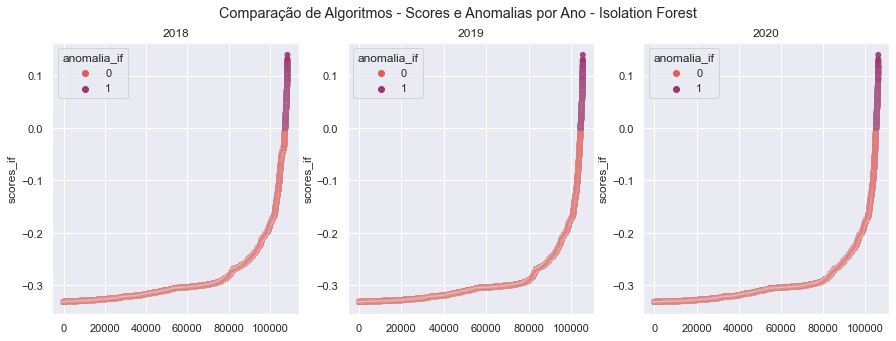

In [128]:
# Comparativo de Algoritmos - Scores e Anomalias por Ano - iForest
anos = ['2018', '2019', '2020']
fig, axes = plt.subplots(1, 3, figsize=(15,5),sharey=False)
fig.suptitle('Comparação de Algoritmos - Scores e Anomalias por Ano - Isolation Forest')
for i in range (0,3):
    df = result_df.query('ano == "{}"'.format(anos[i])).sort_values(by='scores_if', ignore_index=True)
    sns.scatterplot(ax=axes[i], data=df,
                    x=df.index, y='scores_if', hue='anomalia_if',
                   alpha=0.9, palette='flare', linewidth=0.05)
    plt.subplots_adjust(wspace = 0.2)
    #axes[i].set(yscale='log')
    #axes[i].set(xscale='log')
    axes[i].set_title(anos[i])

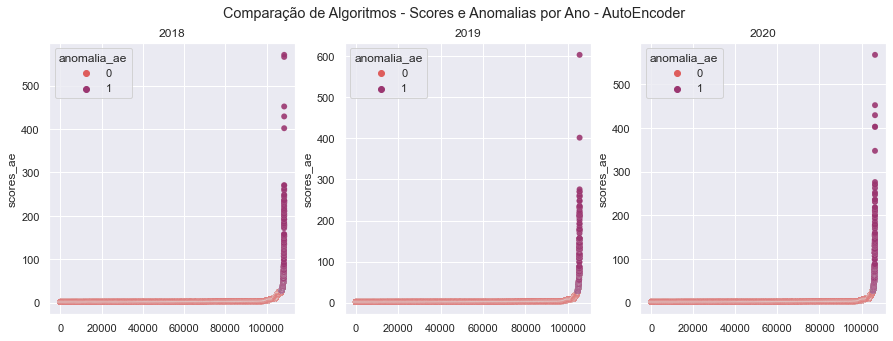

In [129]:
# Comparativo de Algoritmos - Scores e Anomalias por Ano - AutoEncoder
anos = ['2018', '2019', '2020']
fig, axes = plt.subplots(1, 3, figsize=(15,5),sharey=False)
fig.suptitle('Comparação de Algoritmos - Scores e Anomalias por Ano - AutoEncoder')
for i in range (0,3):
    df = result_df.query('ano == "{}"'.format(anos[i])).sort_values(by='scores_ae', ignore_index=True)
    sns.scatterplot(ax=axes[i], data=df,
                    x=df.index, y='scores_ae', hue='anomalia_ae',
                   alpha=0.9, palette='flare', linewidth=0.05)
    plt.subplots_adjust(wspace = 0.2)
    #axes[i].set(yscale='log')
    #axes[i].set(xscale='log')
    axes[i].set_title(anos[i])

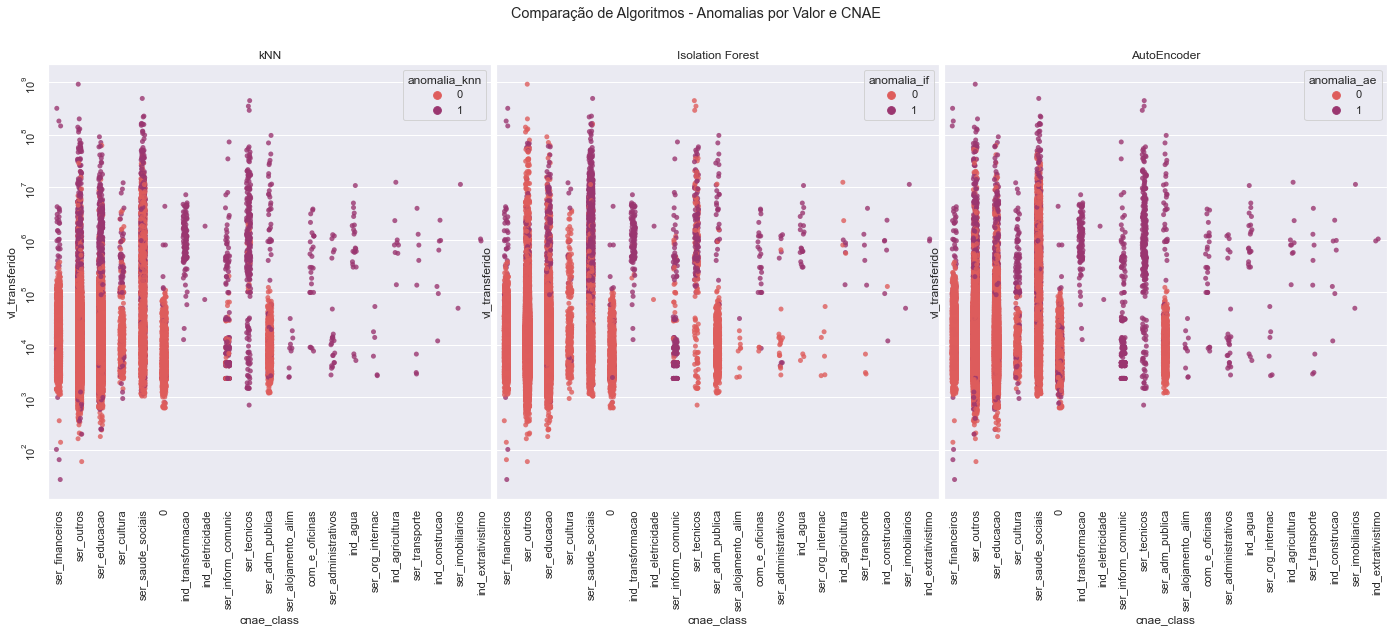

In [145]:
# Anomalias por Valor e CNAE
hues = ['anomalia_knn', 'anomalia_if', 'anomalia_ae']
titulos = ['kNN', 'Isolation Forest', 'AutoEncoder']
fig, axes = plt.subplots(1, 3, figsize=(24,8), sharey=True)
fig.suptitle('Comparação de Algoritmos - Anomalias por Valor e CNAE')
for i in range (0,3):
    sns.stripplot(ax=axes[i], data=result_df, x='cnae_class', y='vl_transferido', hue=hues[i], palette='flare',
                   alpha=0.8)
    axes[i].tick_params(labelrotation=90)
    plt.subplots_adjust(wspace = 0.01)
    axes[i].set(yscale='log')
    #axes[i].set(xscale=x_scale)
    axes[i].set_title(titulos[i])

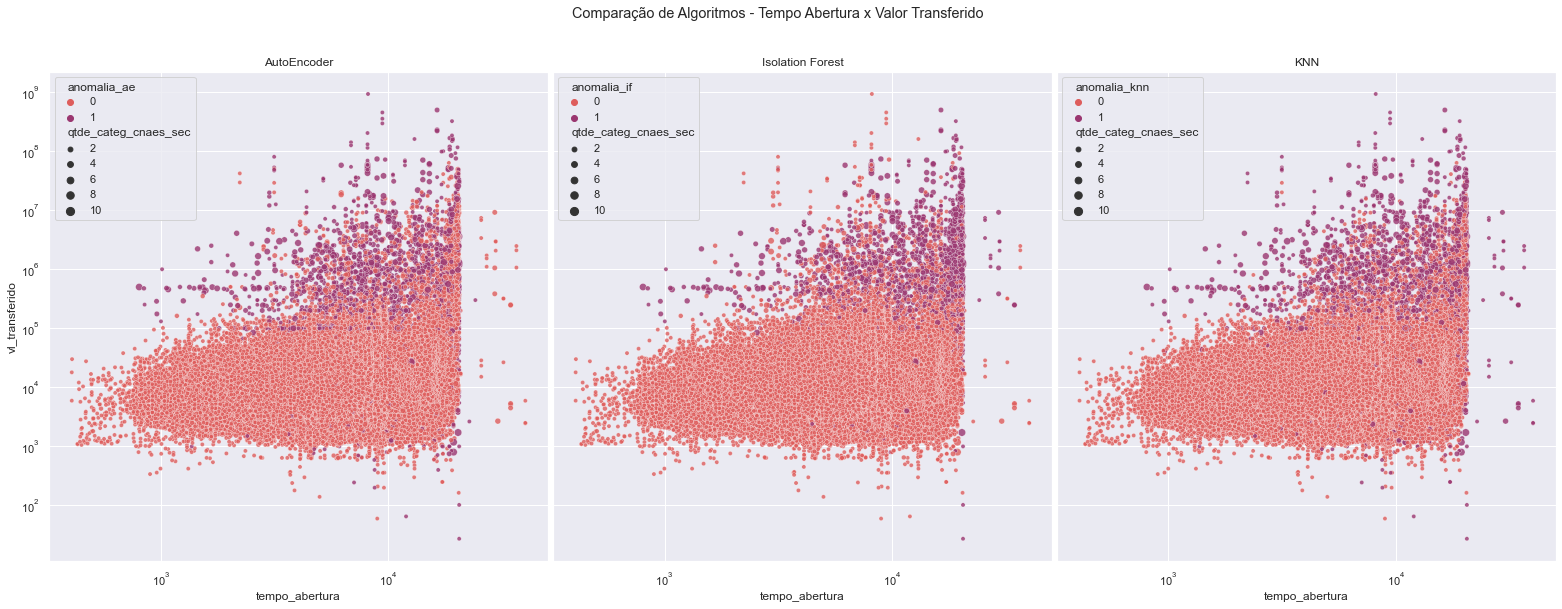

In [146]:
# Comparação Modelos - Tempo Abertura x Valor Transferido
compara_modelos(df=result_df, x_axis='tempo_abertura', y_axis='vl_transferido', 
                size='qtde_categ_cnaes_sec', main_title='Tempo Abertura x Valor Transferido')

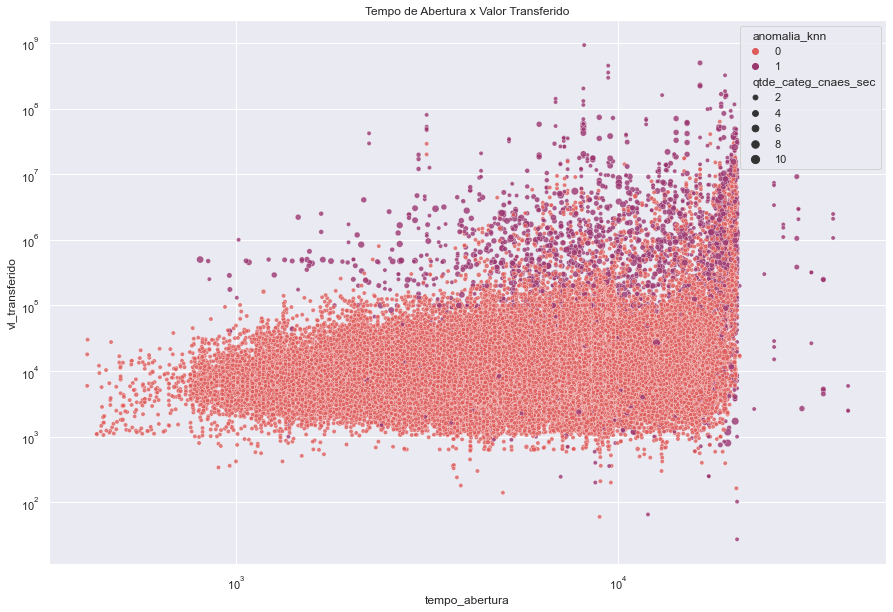

In [148]:
# RESULTADOS
res_tempo_abert = sns.scatterplot(data=result_df, x='tempo_abertura', y='vl_transferido', 
                size='qtde_categ_cnaes_sec', hue='anomalia_knn', alpha=0.8,
               palette='flare')
res_tempo_abert.set(yscale='log')
res_tempo_abert.set(xscale='log')
plt.title('Tempo de Abertura x Valor Transferido')
res_tempo_abert.figure.set_figheight(10)
res_tempo_abert.figure.set_figwidth(15)

### Convergência de anomalias

In [151]:
conv_anom = result_df.query('anomalia_ae == anomalia_if and anomalia_if == anomalia_knn and anomalia_ae == 1')
conv_anom

,ano,cnpj8,cnpj,abertura,tempo_abertura,situacao,porte,capital_social,tp_favorecido,cnae_cd,cnae_desc,cnae_class,nm_funcao,qt_nm_orgao,qt_nm_subfuncao,qt_nm_programa,qt_nm_acao,qt_nm_modalid_aplic_despesa,qt_nm_elemento_despesa,qt_filiais,max_qtde_emp_socios,qtde_total_emp_socios,qtde_socios_na_emp,qtde_empresas_distintas_socios,qtde_cnaes_sec,qtde_categ_cnaes_sec,vl_transferido,anomalia_ae,scores_ae,anomalia_if,scores_if,anomalia_knn,scores_knn
0,2018,00000000,00.000.000/0001-91,01/08/1966,20460,ATIVA,DEMAIS,90000000000.00,Entidades Empresariais Privadas,64.22-1-00,"Bancos múltiplos, com carteira comercial",ser_financeiros,Saúde,99,32,40,52,7,6,6,1.00,59.00,59.00,1.00,1,1,8138.56,1,210.23,1,0.13,1,1.41
1,2018,00000000,00.000.000/0001-91,01/08/1966,20460,ATIVA,DEMAIS,90000000000.00,Entidades Empresariais Privadas,64.22-1-00,"Bancos múltiplos, com carteira comercial",ser_financeiros,Ciência e Tecnologia,99,32,40,52,7,6,6,1.00,59.00,59.00,1.00,1,1,104001.65,1,211.45,1,0.11,1,1.41
2,2018,00000000,00.000.000/0001-91,01/08/1966,20460,ATIVA,DEMAIS,90000000000.00,Entidades Empresariais Privadas,64.22-1-00,"Bancos múltiplos, com carteira comercial",ser_financeiros,Gestão ambiental,99,32,40,52,7,6,6,1.00,59.00,59.00,1.00,1,1,965874.87,1,224.74,1,0.12,1,1.41
3,2018,00000000,00.000.000/0001-91,01/08/1966,20460,ATIVA,DEMAIS,90000000000.00,Entidades Empresariais Privadas,64.22-1-00,"Bancos múltiplos, com carteira comercial",ser_financeiros,Encargos especiais,99,32,40,52,7,6,6,1.00,59.00,59.00,1.00,1,1,1499746.52,1,213.82,1,0.13,1,1.41
4,2018,00000000,00.000.000/0001-91,01/08/1966,20460,ATIVA,DEMAIS,90000000000.00,Entidades Empresariais Privadas,64.22-1-00,"Bancos múltiplos, com carteira comercial",ser_financeiros,Múltiplo,99,32,40,52,7,6,6,1.00,59.00,59.00,1.00,1,1,1032567.85,1,235.67,1,0.12,1,1.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320342,2020,95815668,95.815.668/0001-01,14/06/1973,17746,ATIVA,DEMAIS,0.00,Entidades Sem Fins Lucrativos,86.10-1-01,"Atividades de atendimento hospitalar, exceto p...",ser_saude_sociais,Saúde,1,1,2,2,2,3,1,1.00,1.00,1.00,1.00,33,1,4201974.32,1,36.43,1,0.05,1,0.28
320364,2020,96216841,96.216.841/0001-00,10/06/1969,19093,ATIVA,DEMAIS,0.00,Entidades Sem Fins Lucrativos,85.32-5-00,Educação superior - graduação e pós-graduação,ser_educacao,Ciência e Tecnologia,2,2,2,2,2,2,3,1.00,1.00,1.00,1.00,28,4,900000.00,1,47.23,1,0.04,1,0.47
320365,2020,96216841,96.216.841/0001-00,10/06/1969,19093,ATIVA,DEMAIS,0.00,Entidades Sem Fins Lucrativos,85.32-5-00,Educação superior - graduação e pós-graduação,ser_educacao,Organização agrária,2,2,2,2,2,2,3,1.00,1.00,1.00,1.00,28,4,90314.62,1,135.96,1,0.03,1,0.79
320406,2020,96792254,96.792.254/0001-69,01/06/1993,10600,ATIVA,DEMAIS,480000.00,Entidades Empresariais Privadas,86.10-1-01,"Atividades de atendimento hospitalar, exceto p...",ser_saude_sociais,Saúde,1,1,2,1,1,1,1,1.00,17.00,17.00,1.00,1,1,279849.60,1,35.12,1,0.07,1,0.25


In [158]:
conv_anom.loc[0]

ano                                                                   2018
cnpj8                                                             00000000
cnpj                                                    00.000.000/0001-91
abertura                                                        01/08/1966
tempo_abertura                                                       20460
situacao                                                             ATIVA
porte                                                               DEMAIS
capital_social                                              90000000000.00
tp_favorecido                              Entidades Empresariais Privadas
cnae_cd                                                         64.22-1-00
cnae_desc                         Bancos múltiplos, com carteira comercial
cnae_class                                                 ser_financeiros
nm_funcao                                                            Saúde
qt_nm_orgao              

In [159]:
conv_anom.loc[320507]

ano                                                                            2020
cnpj8                                                                      97577928
cnpj                                                             97.577.928/0001-75
abertura                                                                 15/09/1966
tempo_abertura                                                                20210
situacao                                                                      ATIVA
porte                                                                        DEMAIS
capital_social                                                                 0.00
tp_favorecido                                         Entidades Sem Fins Lucrativos
cnae_cd                                                                  86.10-1-01
cnae_desc                         Atividades de atendimento hospitalar, exceto p...
cnae_class                                                        ser_saude_

In [162]:
df_cnae_sec.query('cnpj8 == "97577928"')

,cnpj8,cnae_sec_cd,cnae_sec_desc,cnae_class
184203,97577928,47.29-6-02,Comércio varejista de mercadorias em lojas de ...,com_e_oficinas
184204,97577928,52.23-1-00,Estacionamento de veículos,ser_transporte
184205,97577928,56.11-2-01,Restaurantes e similares,ser_alojamento_alim
184206,97577928,56.20-1-03,Cantinas - serviços de alimentação privativos,ser_alojamento_alim
184207,97577928,86.10-1-02,Atividades de atendimento em pronto-socorro e ...,ser_saude_sociais
184208,97577928,86.30-5-01,Atividade médica ambulatorial com recursos par...,ser_saude_sociais
184209,97577928,86.30-5-02,Atividade médica ambulatorial com recursos par...,ser_saude_sociais
184210,97577928,86.30-5-99,Atividades de atenção ambulatorial não especif...,ser_saude_sociais
184211,97577928,86.40-2-02,Laboratórios clínicos,ser_saude_sociais
184212,97577928,86.40-2-04,Serviços de tomografia,ser_saude_sociais


In [168]:
conv_anom.loc[conv_anom['tempo_abertura']==conv_anom['tempo_abertura'].quantile(interpolation='nearest')]

,ano,cnpj8,cnpj,abertura,tempo_abertura,situacao,porte,capital_social,tp_favorecido,cnae_cd,cnae_desc,cnae_class,nm_funcao,qt_nm_orgao,qt_nm_subfuncao,qt_nm_programa,qt_nm_acao,qt_nm_modalid_aplic_despesa,qt_nm_elemento_despesa,qt_filiais,max_qtde_emp_socios,qtde_total_emp_socios,qtde_socios_na_emp,qtde_empresas_distintas_socios,qtde_cnaes_sec,qtde_categ_cnaes_sec,vl_transferido,anomalia_ae,scores_ae,anomalia_if,scores_if,anomalia_knn,scores_knn
94452,2018,42772319,42.772.319/0001-85,17/08/1992,10742,ATIVA,DEMAIS,0.00,Entidades Sem Fins Lucrativos,94.99-5-00,Atividades associativas não especificadas ante...,ser_outros,Ciência e Tecnologia,0,1,1,1,1,2,1,1.00,10.00,10.00,1.00,3,3,600000.00,1,29.74,1,0.02,1,0.28
200431,2019,42772319,42.772.319/0001-85,17/08/1992,10742,ATIVA,DEMAIS,0.00,Entidades Sem Fins Lucrativos,94.99-5-00,Atividades associativas não especificadas ante...,ser_outros,Ciência e Tecnologia,0,1,1,1,1,2,1,1.00,10.00,10.00,1.00,3,3,200000.00,1,29.74,1,0.02,1,0.28
306854,2020,42772319,42.772.319/0001-85,17/08/1992,10742,ATIVA,DEMAIS,0.00,Entidades Sem Fins Lucrativos,94.99-5-00,Atividades associativas não especificadas ante...,ser_outros,Ciência e Tecnologia,0,1,1,1,1,2,1,1.00,10.00,10.00,1.00,3,3,200000.00,1,29.74,1,0.02,1,0.28


In [169]:
conv_anom.loc[94452]

ano                                                                            2018
cnpj8                                                                      42772319
cnpj                                                             42.772.319/0001-85
abertura                                                                 17/08/1992
tempo_abertura                                                                10742
situacao                                                                      ATIVA
porte                                                                        DEMAIS
capital_social                                                                 0.00
tp_favorecido                                         Entidades Sem Fins Lucrativos
cnae_cd                                                                  94.99-5-00
cnae_desc                         Atividades associativas não especificadas ante...
cnae_class                                                               ser

In [170]:
df_cnae_sec.query('cnpj8 == "42772319"')

,cnpj8,cnae_sec_cd,cnae_sec_desc,cnae_class
155470,42772319,62.04-0-00,Consultoria em tecnologia da informação,ser_inform_comunic
155471,42772319,71.20-1-00,Testes e análises técnicas,ser_tecnicos
155472,42772319,85.99-6-04,Treinamento em desenvolvimento profissional e ...,ser_educacao


In [194]:
result_df[(result_df['vl_transferido'] % 100000 == 0) & (result_df['vl_transferido'] != 0)]

,ano,cnpj8,cnpj,abertura,tempo_abertura,situacao,porte,capital_social,tp_favorecido,cnae_cd,cnae_desc,cnae_class,nm_funcao,qt_nm_orgao,qt_nm_subfuncao,qt_nm_programa,qt_nm_acao,qt_nm_modalid_aplic_despesa,qt_nm_elemento_despesa,qt_filiais,max_qtde_emp_socios,qtde_total_emp_socios,qtde_socios_na_emp,qtde_empresas_distintas_socios,qtde_cnaes_sec,qtde_categ_cnaes_sec,vl_transferido,anomalia_ae,scores_ae,anomalia_if,scores_if,anomalia_knn,scores_knn
58,2018,00076359,00.076.359/0001-42,20/05/1994,10101,ATIVA,DEMAIS,0.00,Entidades Sem Fins Lucrativos,90.01-9-02,Produção musical,ser_cultura,Cultura,1,1,1,1,1,1,1,1.00,1.00,1.00,1.00,4,3,200000.00,1,39.93,0,-0.02,1,0.16
471,2018,00471150,00.471.150/0001-83,08/03/1995,9661,ATIVA,DEMAIS,0.00,Entidades Sem Fins Lucrativos,94.30-8-00,Atividades de associações de defesa de direito...,ser_outros,Desporto e lazer,0,1,1,1,1,1,1,1.00,1.00,1.00,1.00,2,1,100000.00,1,69.61,0,-0.17,1,0.10
527,2018,00509612,00.509.612/0001-04,19/06/1978,15915,ATIVA,DEMAIS,0.00,Entidades Empresariais Privadas,74.90-1-03,Serviços de agronomia e de consultoria às ativ...,ser_tecnicos,Organização agrária,2,4,4,4,1,2,1,1.00,2.00,2.00,1.00,1,1,500000.00,1,137.33,1,0.02,1,1.42
2851,2018,00765384,00.765.384/0001-33,27/07/1995,9668,ATIVA,DEMAIS,0.00,Entidades Sem Fins Lucrativos,86.10-1-01,"Atividades de atendimento hospitalar, exceto p...",ser_saude_sociais,Saúde,1,1,1,1,1,1,1,1.00,1.00,1.00,1.00,1,1,200000.00,0,14.78,0,-0.03,0,0.02
7762,2018,01499271,01.499.271/0001-04,23/10/1996,9214,ATIVA,DEMAIS,0.00,Entidades Sem Fins Lucrativos,94.30-8-00,Atividades de associações de defesa de direito...,ser_outros,Cultura,1,1,1,1,1,1,1,1.00,1.00,1.00,1.00,9,4,300000.00,1,31.08,0,-0.03,0,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317411,2020,86445293,86.445.293/0001-36,20/03/1970,18928,ATIVA,DEMAIS,0.00,Entidades Sem Fins Lucrativos,85.31-7-00,Educação superior - graduação,ser_educacao,Ciência e Tecnologia,1,2,2,3,1,1,1,1.00,1.00,1.00,1.00,10,5,500000.00,1,32.58,1,0.02,1,0.25
317591,2020,87656567,87.656.567/0001-07,30/06/1972,18095,ATIVA,DEMAIS,0.00,Entidades Sem Fins Lucrativos,94.30-8-00,Atividades de associações de defesa de direito...,ser_outros,Educação,1,1,1,1,1,1,1,1.00,1.00,1.00,1.00,7,3,100000.00,0,10.58,0,-0.10,0,0.03
320094,2020,94185683,94.185.683/0001-42,25/10/1991,11039,ATIVA,DEMAIS,0.00,Entidades Sem Fins Lucrativos,94.30-8-00,Atividades de associações de defesa de direito...,ser_outros,Cultura,1,1,1,1,1,1,1,1.00,1.00,1.00,1.00,2,1,100000.00,0,27.36,0,-0.16,0,0.06
320356,2020,95990297,95.990.297/0001-96,15/01/1993,10591,ATIVA,DEMAIS,0.00,Entidades Sem Fins Lucrativos,94.30-8-00,Atividades de associações de defesa de direito...,ser_outros,Direitos da cidadania,1,1,1,1,1,1,1,1.00,1.00,1.00,1.00,2,1,200000.00,1,33.55,0,-0.14,0,0.03


### Divergência de anomalias

In [197]:
div_anom = result_df.query('anomalia_ae != anomalia_if or anomalia_ae != anomalia_knn')
div_anom

,ano,cnpj8,cnpj,abertura,tempo_abertura,situacao,porte,capital_social,tp_favorecido,cnae_cd,cnae_desc,cnae_class,nm_funcao,qt_nm_orgao,qt_nm_subfuncao,qt_nm_programa,qt_nm_acao,qt_nm_modalid_aplic_despesa,qt_nm_elemento_despesa,qt_filiais,max_qtde_emp_socios,qtde_total_emp_socios,qtde_socios_na_emp,qtde_empresas_distintas_socios,qtde_cnaes_sec,qtde_categ_cnaes_sec,vl_transferido,anomalia_ae,scores_ae,anomalia_if,scores_if,anomalia_knn,scores_knn
58,2018,00076359,00.076.359/0001-42,20/05/1994,10101,ATIVA,DEMAIS,0.00,Entidades Sem Fins Lucrativos,90.01-9-02,Produção musical,ser_cultura,Cultura,1,1,1,1,1,1,1,1.00,1.00,1.00,1.00,4,3,200000.00,1,39.93,0,-0.02,1,0.16
62,2018,00081876,00.081.876/0001-00,01/06/1994,10235,ATIVA,DEMAIS,300000.00,Entidades Empresariais Privadas,86.30-5-01,Atividade médica ambulatorial com recursos par...,ser_saude_sociais,Saúde,1,1,1,1,1,1,1,1.00,3.00,3.00,1.00,2,1,299859.72,1,28.13,1,0.07,0,0.04
64,2018,00082080,00.082.080/0001-71,27/05/1994,10094,ATIVA,EMPRESA DE PEQUENO PORTE,1200.00,Entidades Empresariais Privadas,86.30-5-02,Atividade médica ambulatorial com recursos par...,ser_saude_sociais,Saúde,1,1,2,1,1,1,1,1.00,2.00,2.00,1.00,1,1,49169.28,1,53.99,1,0.02,0,0.03
144,2018,00135993,00.135.993/0001-09,08/08/1994,10021,BAIXADA,DEMAIS,0.00,Entidades Sem Fins Lucrativos,00.00-0-00,********,0,Educação,1,1,1,1,1,2,1,NaN,NaN,NaN,NaN,1,1,8190.00,1,34.76,0,-0.05,0,0.01
145,2018,00136446,00.136.446/0001-48,08/08/1994,10021,ATIVA,EMPRESA DE PEQUENO PORTE,1200000.00,Entidades Empresariais Privadas,86.40-2-03,Serviços de diálise e nefrologia,ser_saude_sociais,Saúde,1,1,1,1,1,1,1,1.00,6.00,6.00,1.00,1,1,732000.00,1,54.39,1,0.10,0,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320444,2020,97503676,97.503.676/0001-30,10/10/1967,19820,ATIVA,DEMAIS,0.00,Entidades Sem Fins Lucrativos,86.10-1-01,"Atividades de atendimento hospitalar, exceto p...",ser_saude_sociais,Saúde,1,1,2,2,2,3,1,1.00,1.00,1.00,1.00,1,1,1174682.78,0,17.58,1,0.01,0,0.00
320510,2020,98104193,98.104.193/0001-25,22/09/1966,20203,ATIVA,DEMAIS,0.00,Entidades Sem Fins Lucrativos,86.10-1-01,"Atividades de atendimento hospitalar, exceto p...",ser_saude_sociais,Saúde,1,1,2,2,2,3,1,1.00,1.00,1.00,1.00,4,2,170324.68,0,18.15,1,0.05,0,0.06
320511,2020,98110000,98.110.000/0001-49,22/02/1968,19685,ATIVA,DEMAIS,0.00,Entidades Sem Fins Lucrativos,86.10-1-01,"Atividades de atendimento hospitalar, exceto p...",ser_saude_sociais,Saúde,1,1,2,2,2,3,1,1.00,1.00,1.00,1.00,5,1,1868862.87,0,17.87,1,0.04,0,0.03
320515,2020,98416225,98.416.225/0001-28,20/08/1968,19505,ATIVA,DEMAIS,0.00,Entidades Sem Fins Lucrativos,86.10-1-01,"Atividades de atendimento hospitalar, exceto p...",ser_saude_sociais,Saúde,1,1,2,1,1,1,1,1.00,1.00,1.00,1.00,2,2,4875222.90,0,15.53,1,0.01,0,0.04


In [198]:
div_anom.loc[58]

ano                                                        2018
cnpj8                                                  00076359
cnpj                                         00.076.359/0001-42
abertura                                             20/05/1994
tempo_abertura                                            10101
situacao                                                  ATIVA
porte                                                    DEMAIS
capital_social                                             0.00
tp_favorecido                     Entidades Sem Fins Lucrativos
cnae_cd                                              90.01-9-02
cnae_desc                                      Produção musical
cnae_class                                          ser_cultura
nm_funcao                                               Cultura
qt_nm_orgao                                                   1
qt_nm_subfuncao                                               1
qt_nm_programa                          

In [199]:
df_cnae_sec.query('cnpj8 == "00076359"')

,cnpj8,cnae_sec_cd,cnae_sec_desc,cnae_class
80,00076359,32.20-5-00,"Fabricação de instrumentos musicais, peças e a...",ind_transformacao
81,00076359,85.92-9-03,Ensino de música,ser_educacao
82,00076359,94.30-8-00,Atividades de associações de defesa de direito...,ser_outros
83,00076359,94.93-6-00,Atividades de organizações associativas ligada...,ser_outros


In [200]:
div_anom.loc[62]

ano                                                                            2018
cnpj8                                                                      00081876
cnpj                                                             00.081.876/0001-00
abertura                                                                 01/06/1994
tempo_abertura                                                                10235
situacao                                                                      ATIVA
porte                                                                        DEMAIS
capital_social                                                            300000.00
tp_favorecido                                       Entidades Empresariais Privadas
cnae_cd                                                                  86.30-5-01
cnae_desc                         Atividade médica ambulatorial com recursos par...
cnae_class                                                        ser_saude_

In [201]:
div_anom.loc[320517]

ano                                                                            2020
cnpj8                                                                      98591910
cnpj                                                             98.591.910/0001-90
abertura                                                                 02/12/1966
tempo_abertura                                                                20425
situacao                                                                      ATIVA
porte                                                                        DEMAIS
capital_social                                                                 0.00
tp_favorecido                                         Entidades Sem Fins Lucrativos
cnae_cd                                                                  86.10-1-01
cnae_desc                         Atividades de atendimento hospitalar, exceto p...
cnae_class                                                        ser_saude_

In [202]:
df_cnae_sec.query('cnpj8 == "98591910"')

,cnpj8,cnae_sec_cd,cnae_sec_desc,cnae_class
184240,98591910,86.10-1-02,Atividades de atendimento em pronto-socorro e ...,ser_saude_sociais
184241,98591910,86.40-2-02,Laboratórios clínicos,ser_saude_sociais
184242,98591910,86.40-2-07,Serviços de diagnóstico por imagem sem uso de ...,ser_saude_sociais
184243,98591910,86.40-2-08,Serviços de diagnóstico por registro gráfico -...,ser_saude_sociais
184244,98591910,86.40-2-09,Serviços de diagnóstico por métodos ópticos - ...,ser_saude_sociais


In [203]:
div_anom.loc[144]

ano                                                        2018
cnpj8                                                  00135993
cnpj                                         00.135.993/0001-09
abertura                                             08/08/1994
tempo_abertura                                            10021
situacao                                                BAIXADA
porte                                                    DEMAIS
capital_social                                             0.00
tp_favorecido                     Entidades Sem Fins Lucrativos
cnae_cd                                              00.00-0-00
cnae_desc                                              ********
cnae_class                                                    0
nm_funcao                                              Educação
qt_nm_orgao                                                   1
qt_nm_subfuncao                                               1
qt_nm_programa                          

### Modelo Ensemble - Votação

In [210]:
result_df['anomalia_voting'] = round((result_df['anomalia_ae']+result_df['anomalia_if']+result_df['anomalia_knn'])/3)
result_df['anomalia_voting'].value_counts()

0.00    317663
1.00      2857
Name: anomalia_voting, dtype: int64

In [211]:
result_df['anomalia_voting']

0        1.00
1        1.00
2        1.00
3        1.00
4        1.00
         ... 
320515   0.00
320516   0.00
320517   0.00
320518   0.00
320519   0.00
Name: anomalia_voting, Length: 320520, dtype: float64

In [216]:
result_df.query('anomalia_voting == 1').nunique()['cnpj8']

1422